# Members

Ignacio Becerra Aguilar `A13530498`
- Scraped data for Median Income, Unemployment Rate, Mean Commute Time
- Data Analysis

Glenn Raskovich `A13376931`
- Collected, cleaned and formatted data for Happiness
- Edited explanations

Karina DuBourdieu `A12698179`
- Research and datafinding
- Conclusion

Shirley Han `A13798277`
- Introduction and Background
- Privacy & Ethics Consideration
- Data Visualization Explanation

Zhizhu Wang `A13324426`
- Cost of Living collection
- Data Visualization

Michael Liu `A12314038`
- Crime Data collection
- Data Analysis and Results

# Introduction and Background

### Research Question

Is it possible to predict the happiest city in the United States? If so, where and how exactly is it the happiest?

### Hypothesis

The happiest city in the United States will have most of the population with a roof over their heads, a stable job, a low crime rate, and good traffic conditions. We predict that the cities with a good employment rate will see it increase over upcoming years and eventually help residents buy houses and other commodities, reducing the need to commit crimes. This would eventually result in the happiest city in the United States. 


### Background

**1. Why did we choose this project?**


The question of predicting happiness based on these factors interests us because we are all from different cities in the United States, and we have different stories about our cities. We want to see which city in the United States would be the best one to live in. When pinpointing factors such as crime and others, we realized that there are many major issues that we can dive into. We initially thought of predicting the income of cities which led to our current project of using income, unemployment, average traffic time, and crime data. We want to understand why some cities are happier than others, and how can we make all cities better.

In this project, we have utilized various datasets to analyze and predict the happiest city in the United States. By completing this project we hope to provide useful information for others to make decisions regarding relocation, recognize living standards and crime rates, and understand each city’s social mobility. As work relocation becoming more and more relevant for college students, we hope that by using the result from this project we can help ease this process as much as possible. In addition, as part of our research, we discover that happy individuals tend to have a longer lifespan (1) and we believe our project can potentially help people become happier. We have chosen 105 cities throughout the 50 states for our study.


References:


https://onlinelibrary.wiley.com/doi/full/10.1111/j.1758-0854.2010.01045.x 

Diener, E. and Chan, M. Y. (2011), Happy People Live Longer: Subjective Well‐Being Contributes to Health and Longevity. Applied Psychology: Health and Well‐Being, 3: 1-43. doi:10.1111/j.1758-0854.2010.01045.x

**2. What sources help us decide which dataset to use?**


The first study (1) was suggested to us by Professor Voytek. It essentially analyzes data to find the happiest state in the United States, defining happiness as well-being. It introduces many concepts that help the researchers give a numerical value to well-being as well as calculating said number from datasets. It relates to our project since it accomplishes what we are trying to achieve, albeit in a smaller scale of a single country. It takes many variables into account and discusses any confounding variables that could skew results, giving us a certain guide on how to proceed if issues like this arise.

The second (2) source discusses the specifics of the relationship between happiness and money. Since we hypothesize that better employment rates will eventually result in a happier city overall, we need to understand the underlying meaning of happiness in this scenario. How it makes people happier, any consequences of a sudden gain in wealth, and so on. These publications will certainly help us arrive at a conclusion on the definition of happiness in cities when correlated to money directly. While wealth may resolve any problems for cities, it can also backfire in many ways, and we need to consider any possible negative effects of growing employment rates. The third resource (3) can help describe ways people may react, and we can adjust data accordingly and make better predictions.

References:
(1) Objective Confirmation of Subjective Measures of Human Well-Being

      https://www.cbsnews.com/htdocs/pdf/Oswald-12-18-09.pdf
      
(2) Can Money Buy You Happiness? 

      http://time.com/4856954/can-money-buy-you-happiness/
      
(3) This Is Why Rich People Aren't Always Happy

      http://time.com/money/4363201/wealth-rich-happiness-people/
      

**3. How did we choose the 105 cities?**


From the 50 states in United States, we included at least two most populated cities from each state, so we can have each state represented in our study.

# Data Description

## Income
There is a general belief that the wealthier people are the happier they are. There is research on the matter correlating happiness to a sudden money increase (http://time.com/4856954/can-money-buy-you-happiness/), but over time people will compare themselves to other rich people, leading them to a neverending search for more wealth with hopes that it will lead to more happiness...but will it?

Whether or not money makes people happier, it is certainly an important part of people's lives. With money people are able to buy houses, commodities, and luxuries. We are interested in knowing which city is the happiest based on various factors, and income should be one of the most important. 

In order for our happiness model to be able to predict future values, we need to look at income in a longitudinal manner. In other words, we need data from the recent past to start building our model.

## Unemployment
After the 2008 Economic Crisis, people lost the source of their income: their jobs. Without jobs, families were forced to relocate elsewhere, cities where they could at least afford a home. Others were not as successful finding a home. Unemployment has always been a problem in history, and the effects of this recent example in the job market remains prevalent in the United States.

The main reason there are "major" cities in each state is because of the supposed opportunities that reside within them. People are promised jobs, houses, and generally a good life in these metropolitan areas. Whether those promises hold up with reality is something our project can help answer. 

If there is a low unemployment rate in a city, will the citizens be happier than others?

## Traffic
Suppose citizens have a secure job position that generates a steady source of income. They should be content with their life correct? Ignoring more specific problems that exist everywhere (i.e. marital issues), there is one thing that all working citizens dislike. And that is the commute. 

Commuting can be defined as the trip from home to work, or vice versa. Most jobs have set shifts, meaning that their employees come and leave at the same time, with some time variations. In a perfect situtation, people would have a commute time that is almost nonexistent. But in real life, people wake up earlier than it would be preferable, such as waking up thee hours in advance, only to be on time to their job. Multiply this by hundreds, if not thousands, and you get morning traffic. 

When leaving the job, people just want to get home immediately, but they also need to deal with evening traffic. This causes discomfort that ruins the rest of the day, and makes people angrier, eventually leading to some other problems. A bit of a stretch in the last sentence, but nobody can deny traffic only leads to rage and despair.

We got the average commute time in minutes per city, to see if there's any correlation between shorter time spans and happiness. "Commute time" is a statistic is that it takes into account morning and evening traffic, thus we will be referring the scraped data as "traffic".

## Crime
Crime is definitely a factor that speaks for itself. Crime has always existed since the invention of laws. A city that has a large concentration of crime is definitely a city where the normal population would not be happy. They would be afraid of going outside, afraid of being mugged, killed, or raped...Crime definitely does not equate to happiness.

We would like to choose the city with the least crime, or at least the one whose crime rate does not tip the scale of happiness.

## Happiness

This metric is the trickiest to define yet also the one that we want to be able to predict. Positive emotions are a notoriously tricky metric to define objectively, so we rely on how people report their own wellbeing. We define happiness as the consensus on self-perceived wellbeing in a city.

The data we use is polling data from Gallup. With a sample size per city of a few hundred this data is very useful and should not be too affected by self-selection biases from the poll participants to be inaccurate. Data comes from the years 2014-2016.

With this information in mind, can we build a model that uses factors of income, unemployment, traffic and crime rate to predict how happy people are (or at least how happy they say they are)?

# Data Collection

The code in this section is copied from other Notebooks we used. Running them takes a very long time, and we do not recommend executing them.

## Income, Unemployment, and Traffic

We ran into a couple problems looking for the income data, since we did not find a consistent stream of data for all of our cities. We eventually found the FactsFinder webpage that contains all the Census data from the United States (https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml). 

We were able to successfully find the income of a couple of cities from 2010-2016, and decided to scrape the income data from this website. Another roadblock we ran into was the fact that the website utilizes JavaScript, and the data we wanted to scrape was not readily available to us inside the HTML source code. Instead of using an API such as Mechanize or BeautifulSoup, we had to use Selenium Webdriver, a tool that esentially opens a "hidden" browser that can access the "generated" JavaScript HTML code that is not displayed the moment we access a page.

Yet another critical error kept happening, the fact that Selenium was way too fast and tried to scrape the text that was still loading, resulting in many errors. The only way we managed to fix this was to use Python's time package and make the code stop for 5 seconds before trying to scrape the next set of data from a new page. Lesser values worked sometimes, but we were relying on the internet connection speed, which varied over time. Waiting five seconds made it possible to scrape any kind of data we wanted without running into errors. Doing so made the scraping code take more than an hour, however. We saved the resultant dataframes and converted into CSV files for easy data analysis. 

The next cell contains the scraping code for the median income, unemployment rate, and mean commute time.

In [ ]:
# Importing packages we need
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options 
import selenium.webdriver.support.ui as ui
import time

# Make Selenium invisible for running
chrome_options = Options()  
chrome_options.add_argument("--headless")
br = webdriver.Chrome(chrome_options=chrome_options, executable_path=r'./Income_Data/chromedriver.exe')

In the next cell, we get the list of cities that we are working with, and create the Pandas data frame objects to store all the information we need. We run while loops with the parser function to append elements to a new row, and modify column (year) values per dataframe. 

There are three resultant CSV files:
- cities_median_income.csv
- cities_unemployment_rate.csv
- cities_mean_commute_time.csv

In [ ]:
# Warning: code takes more than an hour to run since we have to wait until every
# page's Javascript content loads. That takes around 1-2 seconds normally, but
# sometimes may take one second longer than that, causing the program to crash.
# We use 5 seconds just in case, to avoid any possible hangups in the process.

# Scrapes median income, unemployment rate, and mean commute times of every city
def scraping_cities(city, row):
  
    br.get("https://factfinder.census.gov/faces/nav/jsf/pages/community_facts.xhtml")
    wait = ui.WebDriverWait(br,15)
    time.sleep(2)
    # Types search terms for a city
    element = wait.until(lambda br:br.find_element_by_id('cfsearchtextbox'))
    element.clear()
    element.send_keys(city)

    # Submits form
    element =  wait.until(lambda br: br.find_element_by_xpath('//*[@id="communityfactssubmit"]'))
    element.click()

    # Clicking the income tab
    time.sleep(2.5)
    element = wait.until(lambda br:br.find_element_by_xpath('//*[@id="leftnav"]/a[7]'))
    element.click()

    # Getting table link
    time.sleep(2.5)
    element = wait.until(lambda br:br.find_element_by_xpath('//*[@id="cf-content"]/div[2]/div[1]/ul[1]/li[1]/div/a'))
    href = element.get_attribute('href')
    br.get(href)

    # Loop to scrape data from 2016 to 2010
    for i in range(2, 9):
        time.sleep(5)
            
        # Append unemployment rate
        element = wait.until(lambda br:br.find_element_by_xpath('//*[@id="data"]/tbody/tr[11]/td[3]'))
        unemploymentDF.iloc[row, i-2] = element.text
        
        # Append commute time rate
        element = wait.until(lambda br:br.find_element_by_xpath('//*[@id="data"]/tbody/tr[33]/td[1]'))
        commuteDF.iloc[row, i-2] = element.text
        
        # Append median income data
        element = wait.until(lambda br:br.find_element_by_xpath('//*[@id="data"]/tbody/tr[79]/td[1]'))
        incomeDF.iloc[row, i-2] = element.text
        
        # Stop from getting nonexistent element
        if i == 8:
            break
        
        # Get previous year
        element = wait.until(lambda br:br.find_element_by_xpath('//*[@id="year_selector_content"]/ul/li['+ str(i) +']/a'))
        element.click()


## Crime

The FBI curates annual crime occurence reports from many cities throughout the United States. Though poorly formatted and riddled with missing points, it is the most comprehensive source for raw crime data we were able to find. Because data for every available city in a given state was presented in a single table, I went ahead and scraped the data for all those cities in case we later might decide to alter the scope of our project.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
def to_val(cell):
    val = cell.get_text().strip().replace(',', '')
    return float(val) if val != '' else np.nan

In [ ]:
typos = { # good job, FBI
    "massachuetts": "massachusetts"
}

In [ ]:
years = [str(year) for year in range(2009, 2016+1)]

In [ ]:
data = []
with requests.Session() as session:
    for year in years:
        print("scraping {year} data for".format(year=year), end=' ')
        if year == '2009':
            states_list_url = "https://www2.fbi.gov/ucr/cius2009/data/table_08.html"
            state_anchors = BeautifulSoup(session.get(states_list_url).content, 'html.parser') \
                                  .find_all(id='page_content')[-1]                             \
                                  .find(class_='secondarywrapper')                             \
                                  .find_all('a')
        else:
            base_url = "https://ucr.fbi.gov/crime-in-the-u.s/{year}/crime-in-the-u.s.-{year}".format(year=year)
            states_list_url = BeautifulSoup(session.get(base_url).content, 'html.parser') \
                                  .find(id='quick_finds')                                 \
                                  .find_next('div')                                       \
                                  .find_next('a')                                         \
                                  .get('href')
            # "secardary" is not a typo on my end
            state_anchors = BeautifulSoup(session.get(states_list_url).content, 'html.parser') \
                                  .find_all(id='page_content')[-1]                             \
                                  .find(class_='secardarywrapper')                             \
                                  .find_all('a')
        for state_anchor in state_anchors:
            state = state_anchor.get_text().strip().lower()
            if state in typos:
                state = typos[state]
            print(state, end=', ')
            state_url = state_anchor.get('href')
            if year == '2009': # 2009 uses relative hrefs
                state_url = states_list_url[:-13] + state_url
                
            table_body = BeautifulSoup(session.get(state_url).content, 'html.parser') \
                              .find_all('table', class_='data')[-1]                   \
                              .find('tbody')
            if year == '2009': # the formatting for 2009 is atrocious
                year_data = []
                for row in table_body.find_all('tr'):
                    cells = row.find_all('td')
                    year_data.append(pd.Series([
                        state,
                        row.find('th').get_text().strip().rstrip("0123456789").lower(), # city
                        year,
                        to_val(cells[0]), # population
                        to_val(cells[2]), # murder
                        to_val(cells[3]), # forcible rape
                        to_val(cells[4]), # robbery
                        to_val(cells[5]), # aggravated assault
                        to_val(cells[7]), # burglary
                        to_val(cells[8]), # larceny or theft
                        to_val(cells[9]), # motor vehicle theft
                        to_val(cells[10]) # arson
                    ]).to_frame().transpose())
                year_df = pd.concat(year_data, ignore_index=True)
                year_df.columns = ['state',
                    'city',
                    'year',
                    'population',
                    'murder',
                    'forcible rape',
                    'robbery',
                    'aggravated assault',
                    'burglary',
                    'larceny or theft',
                    'motor vehicle theft',
                    'arson'
                ]
                data.append(year_df)
            elif year in ['2010', '2011', '2012']:
                data.append(pd.DataFrame({
                    'state': state,
                    'city': [cell.get_text().strip().rstrip("0123456789").lower()
                             for cell in table_body.find_all(class_='group0')],
                    'year': year,
                    'population': [to_val(cell)
                             for cell in table_body.find_all(class_='group1')],
                    'murder': [to_val(cell)
                             for cell in table_body.find_all(class_='group3')],
                    'forcible rape': [to_val(cell)
                             for cell in table_body.find_all(class_='group4')],
                    'robbery': [to_val(cell)
                             for cell in table_body.find_all(class_='group5')],
                    'aggravated assault': [to_val(cell)
                             for cell in table_body.find_all(class_='group6')],
                    'burglary': [to_val(cell)
                             for cell in table_body.find_all(class_='group8')],
                    'larceny or theft': [to_val(cell)
                             for cell in table_body.find_all(class_='group9')],
                    'motor vehicle theft': [to_val(cell)
                             for cell in table_body.find_all(class_='group10')],
                    'arson': [to_val(cell)
                             for cell in table_body.find_all(class_='group11')]
                }))
            else: # the FBI revised their definition of rape in 2013, and added an extra column to the table
                year_data = pd.DataFrame({
                    'state': state,
                    'city': [cell.get_text().strip().rstrip("0123456789").lower()
                             for cell in table_body.find_all(class_='group0')],
                    'year': year,
                    'population': [to_val(cell)
                             for cell in table_body.find_all(class_='group1')],
                    'murder': [to_val(cell)
                             for cell in table_body.find_all(class_='group3')],
                    'rape (revised)': [to_val(cell)
                             for cell in table_body.find_all(class_='group4')],
                    'rape (legacy)': [to_val(cell)
                             for cell in table_body.find_all(class_='group5')],
                    'robbery': [to_val(cell)
                             for cell in table_body.find_all(class_='group6')],
                    'aggravated assault': [to_val(cell)
                             for cell in table_body.find_all(class_='group7')],
                    'burglary': [to_val(cell)
                             for cell in table_body.find_all(class_='group9')],
                    'larceny or theft': [to_val(cell)
                             for cell in table_body.find_all(class_='group10')],
                    'motor vehicle theft': [to_val(cell)
                             for cell in table_body.find_all(class_='group11')],
                    'arson': [to_val(cell)
                             for cell in table_body.find_all(class_='group12')]
                })
                year_data['forcible rape'] = pd.Series([legacy if pd.isnull(revised) else revised
                                                        for revised, legacy
                                                        in zip(
                                                            year_data['rape (revised)'].values,
                                                            year_data['rape (legacy)'].values)],
                                                       index=year_data.index)
                year_data.drop(['rape (revised)', 'rape (legacy)'], axis=1, inplace=True)
                data.append(year_data)
        print('\n')

df = pd.concat(data, ignore_index=True).set_index(['state', 'city', 'year']).sort_index()

scraping 2009 data for alabama, alaska, arizona, arkansas, california, colorado, connecticut, delaware, district of columbia, florida, georgia, hawaii, idaho, illinois, indiana, iowa, kansas, kentucky, louisiana, maine, maryland, massachusetts, michigan, minnesota, mississippi, missouri, montana, nebraska, nevada, new hampshire, new jersey, new mexico, new york, north carolina, north dakota, ohio, oklahoma, oregon, pennsylvania, rhode island, south carolina, south dakota, tennessee, texas, utah, vermont, virginia, washington, west virginia, wisconsin, wyoming, 

scraping 2010 data for alabama, alaska, arizona, arkansas, california, colorado, connecticut, delaware, district of columbia, florida, georgia, hawaii, idaho, illinois, indiana, iowa, kansas, kentucky, louisiana, maine, maryland, massachusetts, michigan, minnesota, mississippi, missouri, montana, nebraska, nevada, new hampshire, new jersey, new mexico, new york, north carolina, north dakota, ohio, oklahoma, oregon, pennsylvania

In [ ]:
df.to_pickle("fbi_crime_data.pkl")

There is also a website, [City-Data](http://www.city-data.com/), which curates multiple types of data for various cities in the United States. They aren't particularly specific about where they get their data from, but they did have some crime statistics not present in the FBI data, so I used them as a second source.

In [ ]:
def to_val(cell):
    val = cell.get_text().split('(')[0].strip().replace(',', '')
    return float(val) if val != 'N/A' else np.nan

In [ ]:
places = {
    "Alabama": [
        "Birmingham",
        "Montgomery",],
    "Alaska": [
        "Anchorage",
        "Juneau",],
    "Arizona": [
        "Phoenix",
        "Tucson",],
    "Arkansas": [
        "Little Rock",
        "Fort Smith",],
    "California": [
        "San Diego",
        "Los Angeles",
        "Sacramento",],
    "Colorado": [
        "Denver",
        "Colorado Springs",
        "Aurora",],
    "Connecticut": [
        "Bridgeport",
        "Hartford",],
    "Delaware": [
        "Dover",
        "Wilmington",],
    "Florida": [
        "Jacksonville",
        "Miami",
        "Tallahassee",],
    "Georgia": [
        "Atlanta",
        "Savannah",],
    "Hawaii": [
        "Honolulu",
        "Kauai",
        "Maui",],
    "Idaho": [
        "Boise",
        "Meridian",],
    "Illinois": [
        "Chicago",
        "Springfield",],
    "Indiana": [
        "Fort Wayne",
        "Indianapolis",],
    "Iowa": [
        "Cedar Rapids",
        "Des Moines",],
    "Kansas": [
        "Topeka",
        "Wichita",],
    "Kentucky": [
        "Frankfort",
        "Louisville",],
    "Louisiana": [
        "Baton Rouge",
        "New Orleans",],
    "Maine": [
        "Augusta",
        "Portland",],
    "Maryland": [
        "Baltimore",
        "Annapolis",],
    "Massachusetts": [
        "Boston",
        "Worcester",],
    "Michigan": [
        "Detroit",
        "Lansing",],
    "Minnesota": [
        "Minneapolis",
        "St. Paul",],
    "Mississippi": [
        "Jackson",
        "Gulfport",],
    "Missouri": [
        "Kansas City",
        "Jefferson City",],
    "Montana": [
        "Billings",
        "Helena",],
    "Nebraska": [
        "Lincoln",
        "Omaha",],
    "Nevada": [
        "Carson City",
        "Las Vegas",
        "Reno",],
    "New Hampshire": [
        "Concord",
        "Manchester",],
    "New Jersey": [
        "Newark",
        "Trenton",],
    "New Mexico": [
        "Albuquerque",
        "Santa Fe",],
    "New York": [
        "Albany",
        "New York City",],
    "North Carolina": [
        "Charlotte",
        "Raleigh",],
    "North Dakota": [
        "Bismarck",
        "Fargo",],
    "Ohio": [
        "Columbus",
        "Cleveland",],
    "Oklahoma": [
        "Oklahoma City",
        "Tulsa",],
    "Oregon": [
        "Portland",
        "Salem",],
    "Pennsylvania": [
        "Harrisburg",
        "Philadelphia",],
    "Rhode Island": [
        "Providence",
        "Warwick",],
    "South Carolina": [
        "Charleston",
        "Columbia",],
    "South Dakota": [
        "Pierre",
        "Sioux Falls",],
    "Tennessee": [
        "Nashville",
        "Memphis",],
    "Texas": [
        "Austin",
        "Houston",],
    "Utah": [
        "Salt Lake City",
        "West Valley City",],
    "Vermont": [
        "Burlington",
        "Montpelier",],
    "Virginia": [
        "Richmond",
        "Virginia Beach",],
    "Washington": [
        "Olympia",
        "Seattle",],
    "West Virginia": [
        "Charleston",
        "Huntington",],
    "Wisconsin": [
        "Madison",
        "Milwaukee",],
    "Wyoming": [
        "Casper",
        "Cheyenne",],
}

In [ ]:
corrections = { # little quirks
    "Boise": "Boise City",
    "New York City": "New York",
}

In [ ]:
data = []
with requests.Session() as session:
    for state, cities in places.items():
        #print("scraping data for {state}:".format(state=state))
        for city in cities:
            #print("{city},".format(city=city)
            state_url = "http://www.city-data.com/crime/crime-{city}-{state}.html" \
                        .format(city=(corrections[city] if city in corrections else city).replace(' ', '-'),
                                state=state.replace(' ', '-'))
            city_soup = BeautifulSoup(session.get(state_url).content, 'html.parser')
            if city_soup.find(id="errormsg"):
                print("unable to find {city}, {state}; skipping"
                      .format(city=city,
                              state=state))
                continue
            table = city_soup.find(id="crimeTab")
            city_data = []
            city_data.append([cell.find('h4').get_text()
                              for cell
                              in table.find('thead').find_all('tr')[-1].find_all('th')][1:])
            for row in table.find('tbody').find_all('tr')[:-1]: # ignore footer
                city_data.append([to_val(cell)
                                  for cell
                                  in row.find_all('td')[1:]])
            data.append(pd.DataFrame({
                'state': state,
                'city': city,
                'year': city_data[0],
                'murder': city_data[1],
                'rape': city_data[2],
                'robbery': city_data[3],
                'assault': city_data[4],
                'burglary': city_data[5],
                'theft': city_data[6],
                'vehicle theft': city_data[7],
                'arson': city_data[8],
            }))
        
df = pd.concat(data, ignore_index=True).set_index(['state', 'city', 'year']).sort_index()

unable to find Honolulu, Hawaii; skipping
unable to find Kauai, Hawaii; skipping
unable to find Maui, Hawaii; skipping
unable to find Carson City, Nevada; skipping
unable to find Nashville, Tennessee; skipping
unable to find West Valley City, Utah; skipping


In [ ]:
df.to_pickle("citydata_crime_data.pkl")

I then combined and reformatted these two DataFrames.

In [ ]:
abbreviations = {
    "Alabama"       : "AL",
    "Alaska"        : "AK",
    "Arizona"       : "AZ",
    "Arkansas"      : "AR",
    "California"    : "CA",
    "Colorado"      : "CO",
    "Connecticut"   : "CT",
    "Delaware"      : "DE",
    "Florida"       : "FL",
    "Georgia"       : "GA",
    "Hawaii"        : "HI",
    "Idaho"         : "ID",
    "Illinois"      : "IL",
    "Indiana"       : "IN",
    "Iowa"          : "IA",
    "Kansas"        : "KS",
    "Kentucky"      : "KY",
    "Louisiana"     : "LA",
    "Maine"         : "ME",
    "Maryland"      : "MD",
    "Massachusetts" : "MA",
    "Michigan"      : "MI",
    "Minnesota"     : "MN",
    "Mississippi"   : "MS",
    "Missouri"      : "MO",
    "Montana"       : "MT",
    "Nebraska"      : "NE",
    "Nevada"        : "NV",
    "New Hampshire" : "NH",
    "New Jersey"    : "NJ",
    "New Mexico"    : "NM",
    "New York"      : "NY",
    "North Carolina": "NC",
    "North Dakota"  : "ND",
    "Ohio"          : "OH",
    "Oklahoma"      : "OK",
    "Oregon"        : "OR",
    "Pennsylvania"  : "PA",
    "Rhode Island"  : "RI",
    "South Carolina": "SC",
    "South Dakota"  : "SD",
    "Tennessee"     : "TN",
    "Texas"         : "TX",
    "Utah"          : "UT",
    "Vermont"       : "VT",
    "Virginia"      : "VA",
    "Washington"    : "WA",
    "West Virginia" : "WV",
    "Wisconsin"     : "WI",
    "Wyoming"       : "WY",
}

In [ ]:
years = list(range(2010, 2016+1))

In [ ]:
missing_places = { # places missing from citydata
    "Hawaii": [
        "Honolulu",
        "Kauai",
        "Maui",],
    "Kentucky": [
        "Louisville",], # not actually missing, but has like no data
    "Nevada": [
        "Carson City",],
    "Tennessee": [
        "Nashville",],
    "Utah": [
        "West Valley City",],
}

In [ ]:
corrections = { # alternative names in fbi
    "Charlotte": "charlotte-mecklenburg",
    "Las Vegas": "las vegas metropolitan police department",
    "Louisville": "louisville metro",
    "Savannah": "savannah-chatham metropolitan",
    "West Valley City": "west valley",
    "New York City": "new york"
}

In [ ]:
citydata = pd.read_pickle("citydata_crime_data.pkl")

In [ ]:
fbi = pd.read_pickle("fbi_crime_data.pkl")

In [ ]:
data = citydata.copy()

In [ ]:
# add populations
data['population'] = np.nan
for state, city, year in zip(data.index.get_level_values('state'),
                             data.index.get_level_values('city'),
                             data.index.get_level_values('year')):
    try:
        fbi.loc[state.lower(), (corrections[city] if city in corrections else city).lower(), year]
    except KeyError:
        continue
    data.loc[state, city, year].loc['population'] = \
            fbi.loc[state.lower(),
                    (corrections[city] if city in corrections else city).lower(),
                    year] \
                   .loc['population']

In [ ]:
# set `fbi` column names to match `data`
fbi.rename({"aggravated assault": "assault",
            "forcible rape": "rape",
            "larceny or theft": "theft",
            "motor vehicle theft": "vehicle theft"},
           axis='columns', inplace=True)
# rearrange `fbi` columns to match `data`
fbi = fbi[data.columns]

In [ ]:
# unfold multiindex to work with
col_order = data.columns
data.reset_index(inplace=True)

In [ ]:
# add missing cities
new_data = []
for state, cities in missing_places.items():
    for city in cities:
        try: # check if `fbi` contains that missing place
            fbi.loc[state.lower(), (corrections.get(city) or city).lower()]
        except KeyError:
            print("fbi does not contain {city}, {state}"
                  .format(city=city, state=state))
            continue
        new_data.append(fbi.loc[state.lower(),(corrections.get(city) or city).lower()]
                        .reset_index()
                        .assign(state=state, city=city))

fbi does not contain Kauai, Hawaii
fbi does not contain Maui, Hawaii
fbi does not contain Carson City, Nevada


In [ ]:
data = pd.concat([data, *new_data]) \
           .sort_values(['state', 'city', 'year']) \
           .drop_duplicates(['state', 'city', 'year'], keep='last')

In [ ]:
# add state abbreviations to city names
data['city'] = data['city'] + ", " + data['state'].apply(lambda state: abbreviations[state])
data.drop('state', axis=1, inplace=True)

In [ ]:
# refold multiindex
data = data.set_index(['city', 'year'])[col_order]

In [ ]:
data.to_pickle("crime_data.pkl")

## Happiness

Gallup, Inc. is a well-known consulting company that conducts regular polls and surveys on a variety of topics. In collaboration with Healthyways, Gallup tracks a Well-Being Index for metropolitan areas in the United States, which they compile into an annual happiness score. We use this as the ground truth values for our regression model.

In [ ]:
import pandas as pd

In [ ]:
# Excel file with city/community well being data
happy_excel = 'Gallup_CommunityWellbeing.xlsx'
# Dependency: Install xlrd >= 0.9.0 for Excel support
df_happy = pd.read_excel(happy_excel)
# Delete first 6 lines as they have unimportant information
df_happy = df_happy.iloc[6:]
# Set columns to first row that has header information
df_happy.columns = df_happy.iloc[0]
# Now that header info from first row is saved as column names, drop first row
df_happy = df_happy.iloc[1:]
# Drop 'Demographic' and 'Demographic Value' columns, as they only contain string 'Aggregate'
df_happy.drop(['Demographic', 'Demographic Value'], axis=1, inplace=True)
# Drop 'N Size' as sample size is not important for our analysis
df_happy.drop(['N Size'], axis=1, inplace=True)

str_geo = 'Geography'
str_val = 'Value'
str_time = 'Time'

df_happy[str_val] = pd.to_numeric(df_happy[str_val])
df_happy[str_time] = pd.to_numeric(df_happy[str_time])

cities = df_happy.groupby(str_geo)

timeline = df_happy.pivot(index=str_geo, columns=str_time, values=str_val)

avg_happy = cities.mean()

print(timeline)
print(avg_happy)

Time                                          2014  2015  2016
Geography                                                     
Akron, OH                                     57.7  60.3  61.7
Albany-Schenectady-Troy, NY                   59.2  60.8  59.9
Albuquerque, NM                               60.3  57.0  59.4
Allentown-Bethlehem-Easton, PA-NJ             61.2  60.4  61.2
Anchorage, AK                                 65.7   NaN  64.4
Asheville, NC                                 66.2  67.9   NaN
Atlanta-Sandy Springs-Roswell, GA             59.7  60.0  60.6
Augusta-Richmond County, GA-SC                61.4  57.8  63.2
Austin-Round Rock, TX                         64.7  64.9  64.4
Bakersfield, CA                               57.2  57.2  57.3
Baltimore-Columbia-Towson, MD                 57.3  58.2  57.8
Baton Rouge, LA                               60.7  56.6  58.8
Birmingham-Hoover, AL                         59.9  63.0  61.6
Boise City, ID                                64.0  63.

In [ ]:
timeline.to_csv('timeline_happy.csv', encoding='utf-8')
avg_happy.to_csv('avg_happy.csv', encoding='utf-8')

# Data Cleaning/Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import scipy.interpolate as sp_interpolate

In [ ]:
# our original wishlist of cities
cities = [
    "Birmingham, AL",
    "Montgomery, AL",
    "Anchorage, AK",
    "Juneau, AK",
    "Phoenix, AZ",
    "Tucson, AZ",
    "Little Rock, AR",
    "Fort Smith, AR",
    "San Diego, CA",
    "Los Angeles, CA",
    "Sacramento, CA",
    "Denver, CO",
    "Colorado Springs, CO",
    "Aurora, CO",
    "Bridgeport, CT",
    "Hartford, CT",
    "Dover, DE",
    "Wilmington, DE",
    "Jacksonville, FL",
    "Miami, FL",
    "Tallahassee, FL",
    "Atlanta, GA",
    "Savannah, GA",
    "Honolulu, HI",
    "Kauai, HI",
    "Maui, HI",
    "Boise, ID",
    "Meridian, ID",
    "Chicago, IL",
    "Springfield, IL",
    "Fort Wayne, IN",
    "Indianapolis, IN",
    "Cedar Rapids, IA",
    "Des Moines, IA",
    "Topeka, KS",
    "Wichita, KS",
    "Frankfort, KY",
    "Louisville, KY",
    "Baton Rouge, LA",
    "New Orleans, LA",
    "Augusta, ME",
    "Portland, ME",
    "Baltimore, MD",
    "Annapolis, MD",
    "Boston, MA",
    "Worcester, MA",
    "Detroit, MA",
    "Lansing, MA",
    "Minneapolis, MN",
    "Saint Paul, MN",
    "Jackson, MS",
    "Gulfport, MS",
    "Kansas City, MO",
    "Jefferson City, MO",
    "Billings, MT",
    "Helena, MT",
    "Lincoln, NE",
    "Omaha, NE",
    "Carson City, NV",
    "Las Vegas, NV",
    "Reno, NV",
    "Concord, NH",
    "Manchester, NH",
    "Newark, NJ",
    "Trenton, NJ",
    "Albuquerque, NM",
    "Santa Fe, NM",
    "Albany, NY",
    "New York City, NY",
    "Charlotte, NC",
    "Raleigh, NC",
    "Bismarck, ND",
    "Fargo, ND",
    "Columbus, OH",
    "Cleveland, OH",
    "Oklahoma City, OK",
    "Tulsa, OK",
    "Portland, OR",
    "Salem, OR",
    "Harrisburg, PA",
    "Philadelphia, PA",
    "Providence, RI",
    "Warwick, RI",
    "Charleston, SC",
    "Columbia, SC",
    "Pierre, SD",
    "Sioux Falls, SD",
    "Nashville, TN",
    "Memphis, TN",
    "Austin, TX",
    "El Paso, TX",
    "Houston, TX",
    "Salt Lake City, UT",
    "West Valley City, UT",
    "Burlington, VT",
    "Montpelier, VT",
    "Richmond, VA",
    "Virginia Beach, VA",
    "Olympia, WA",
    "Seattle, WA",
    "Charleston, WV",
    "Huntington, WV",
    "Madison, WI",
    "Milwaukee, WI",
    "Casper, WY",
    "Cheyenne, WY"
]

## Income

In [ ]:
income = pd.read_csv('Income_Data/cities_median_income.csv')
income.head()

,City,Median Income 2016,Median Income 2015,Median Income 2014,Median Income 2013,Median Income 2012,Median Income 2011,Median Income 2010
0,"Birmingham, AL","46,346","44,463","44,447","44,716","44,710","45,423","45,198"
1,"Montgomery, AL","63,847","62,201","62,568","62,418","61,896","62,645","61,229"
2,"Anchorage, AK","102,500","99,630","98,317","96,935","95,632","94,073","91,251"
3,"Juneau, AK","104,005","102,355","97,588","96,025","95,433","93,994","89,373"
4,"Phoenix, AZ","69,216","66,345","65,770","65,199","65,968","66,709","66,996"


In [ ]:
# rename columns
income.columns = ['city', '2016', '2015', '2014', '2013', '2012', '2011', '2010']

In [ ]:
# capitalize "city" in "Salt Lake City"
income.loc[income['city'] == "Salt Lake city, UT", 'city'] = "Salt Lake City, UT"

In [ ]:
# unpivot
income = pd.melt(income, id_vars=['city'], var_name='year', value_name='median income') \
           .sort_values(['city', 'year']) \
           .reset_index(drop=True)

In [ ]:
# convert strings to numbers
income['median income'] = income['median income'].map(lambda value: int(value.replace(',', '')))

In [ ]:
# convert to MultiIndex
income.set_index(['city', 'year'], inplace=True)

In [ ]:
income.head()

median income
city       year               
Albany, NY 2010          73470
           2011          75821
           2012          76707
           2013          77687
           2014          78285

## Unemployment

In [ ]:
unemployment = pd.read_csv('Income_Data/cities_unemployment_rate.csv')

In [ ]:
unemployment = pd.read_csv('Income_Data/cities_unemployment_rate.csv')
unemployment.head()

,City,Unemployment Rate 2016,Unemployment Rate 2015,Unemployment Rate 2014,Unemployment Rate 2013,Unemployment Rate 2012,Unemployment Rate 2011,Unemployment Rate 2010
0,"Birmingham, AL",11.8%,13.3%,14.5%,15.3%,14.5%,13.6%,12.9%
1,"Montgomery, AL",8.4%,8.8%,8.9%,8.9%,8.7%,8.6%,7.9%
2,"Anchorage, AK",6.0%,6.7%,6.9%,7.3%,7.3%,7.2%,7.4%
3,"Juneau, AK",4.9%,5.2%,5.6%,5.3%,5.1%,5.3%,5.8%
4,"Phoenix, AZ",7.7%,8.8%,9.9%,10.6%,9.7%,8.7%,7.4%


In [ ]:
# rename columns
unemployment.columns = ['city', '2016', '2015', '2014', '2013', '2012', '2011', '2010']

In [ ]:
# capitalize "city" in "Salt Lake City"
unemployment.loc[unemployment['city'] == "Salt Lake city, UT", 'city'] = "Salt Lake City, UT"

In [ ]:
# unpivot
unemployment = pd.melt(unemployment, id_vars=['city'],
                       var_name='year', value_name='unemployment rate') \
                 .sort_values(['city', 'year']) \
                 .reset_index(drop=True)

In [ ]:
# convert percentages to decimals
unemployment['unemployment rate'] = unemployment['unemployment rate'] \
                                    .map(lambda rate: float(rate.rstrip('%'))/100)

In [ ]:
# convert to MultiIndex
unemployment.set_index(['city', 'year'], inplace=True)

In [ ]:
unemployment.head()

unemployment rate
city       year                   
Albany, NY 2010              0.060
           2011              0.065
           2012              0.070
           2013              0.073
           2014              0.068

## Traffic

In [ ]:
traffic = pd.read_csv('Income_Data/cities_mean_commute_time.csv')

In [ ]:
traffic = pd.read_csv('Income_Data/cities_mean_commute_time.csv')
traffic.head()

,City,Mean Commute Time 2016,Mean Commute Time 2015,Mean Commute Time 2014,Mean Commute Time 2013,Mean Commute Time 2012,Mean Commute Time 2011,Mean Commute Time 2010
0,"Birmingham, AL",21.4,21.4,21.6,21.7,21.8,21.7,22.0
1,"Montgomery, AL",20.0,19.3,19.5,19.3,19.5,19.5,19.7
2,"Anchorage, AK",19.1,19.5,19.4,19.4,19.0,18.6,18.2
3,"Juneau, AK",15.6,15.1,14.8,15.1,15.5,15.2,15.3
4,"Phoenix, AZ",25.1,24.8,24.5,24.4,24.4,24.7,24.8


In [ ]:
# rename columns
traffic.columns = ['city', '2016', '2015', '2014', '2013', '2012', '2011', '2010']

In [ ]:
# capitalize "city" in "Salt Lake City"
traffic.loc[traffic['city'] == "Salt Lake city, UT", 'city'] = "Salt Lake City, UT"

In [ ]:
# unpivot
traffic = pd.melt(traffic, id_vars=['city'], var_name='year', value_name='mean commute time') \
            .sort_values(['city', 'year']) \
            .reset_index(drop=True)

In [ ]:
# convert to MultiIndex
traffic.set_index(['city', 'year'], inplace=True)

In [ ]:
traffic.head()

mean commute time
city       year                   
Albany, NY 2010               19.7
           2011               19.9
           2012               20.0
           2013               20.0
           2014               20.1

## Crime

In [ ]:
crime = pd.read_pickle('crime_data/crime_data.pkl')
crime.head()

arson assault burglary murder rape robbery  theft  \
city           year                                                     
Birmingham, AL 2002   211    1697     4389     65  239    1186  11640   
               2003   175    1706     4831     85  204    1352  11934   
               2004   142    1593     5156     59  240    1369  11970   
               2005   136    1675     4933    104  241    1429  11962   
               2006   228    1422     4813    104  220    1429  12113   

                    vehicle theft population  
city           year                           
Birmingham, AL 2002          2049        NaN  
               2003          2809        NaN  
               2004          2351        NaN  
               2005          2028        NaN  
               2006          2081        NaN

In [ ]:
# only keep 2009–2016
crime.drop([str(year) for year in range(2000, 2008+1)], level='year', inplace=True)

In [ ]:
# the only population value we're missing (2009 onward) is Chicago 2013,
# so we'll fill it with the mean of Chicago's 2012 and 2014 populations
crime.loc['Chicago, IL', '2013'].loc['population'] \
    = crime.loc['Chicago, IL'].loc[['2012', '2014'], 'population'].mean()

In [ ]:
# rescale crime values to occurence per capita
for col_name in crime.columns:
    crime[col_name] = crime[col_name]/crime['population']
crime.drop('population', axis=1, inplace=True)
# append "rate" to column names
crime.rename(columns=lambda col_name: col_name + " rate", inplace=True)

In [ ]:
# These cities are missing all data points for these metrics,
# so we'll fill those with zeros
crime.loc['Boston, MA', 'arson rate'] = 0
crime.loc['New York City, NY', 'arson rate'] = 0
crime.loc['Huntington, WV', 'burglary rate'] = 0

In [ ]:
# These cities are missing half or more data points for these metrics,
# so we'll fill them with the means of the available data points for those metrics for each city
crime.loc['Montgomery, AL', 'arson rate'] = crime.loc['Montgomery, AL', 'arson rate'] \
        .fillna(crime.loc['Montgomery, AL', 'arson rate'].mean()) \
        .values
crime.loc['Tucson, AZ', 'theft rate'] = crime.loc['Tucson, AZ', 'theft rate'] \
        .fillna(crime.loc['Tucson, AZ', 'theft rate'].mean()) \
        .values
crime.loc['New Orleans, LA', 'arson rate'] = crime.loc['New Orleans, LA', 'arson rate'] \
        .fillna(crime.loc['New Orleans, LA', 'arson rate'].mean()) \
        .values
crime.loc['Philadelphia, PA', 'arson rate'] = crime.loc['Philadelphia, PA', 'arson rate'] \
        .fillna(crime.loc['Philadelphia, PA', 'arson rate'].mean()) \
        .values

In [ ]:
# These cities are missing just a few data points,
# so we'll fill them by cubic interpolation
def interpolate_crime_data(series):
    x = series.dropna().index.values.astype(int) # year
    y = series.dropna().values # data
    
    f = sp_interpolate.interp1d(x, y, kind='cubic', fill_value='extrapolate')
    x_all = series.index.values.astype(int)
    return f(x_all)

missing_data = [
    ('Birmingham, AL', 'arson rate'),
    ('Phoenix, AZ', 'arson rate'),
    ('Chicago, IL', 'arson rate'),
    ('Chicago, IL', 'assault rate'),
    ('Chicago, IL', 'rape rate'),
    ('Indianapolis, IN', 'arson rate'),
    ('Topeka, KS', 'arson rate'),
    ('Louisville, KY', 'arson rate'),
    ('Lincoln, NE', 'arson rate'),
    ('Omaha, NE', 'arson rate'),
    ('Albuquerque, NM', 'arson rate'),
    ('Santa Fe, NM', 'arson rate'),
    ('Albany, NY', 'arson rate'),
    ('Columbus, OH', 'arson rate'),
    ('Providence, RI', 'vehicle theft rate'),
    ('West Valley City, UT', 'burglary rate'),
    ('Madison, WI', 'arson rate')
]

for city, injustice in missing_data:
    crime.loc[city, injustice] = interpolate_crime_data(crime.loc[city, injustice])

In [ ]:
crime.head()

arson rate assault rate burglary rate  murder rate  \
city           year                                                        
Birmingham, AL 2009  0.000593738   0.00615289     0.0220739  0.000285874   
               2011  0.000576766   0.00898442     0.0272252  0.000253214   
               2012  0.000548611   0.00954207      0.022057  0.000314162   
               2013  0.000606034   0.00774525     0.0189527  0.000297168   
               2014  0.000683591   0.00982486     0.0176791   0.00024515   

                       rape rate robbery rate theft rate vehicle theft rate  
city           year                                                          
Birmingham, AL 2009  0.000870816   0.00505777    0.05078         0.00701051  
               2011  0.000853426   0.00474074  0.0493393         0.00709469  
               2012  0.000712725   0.00460927  0.0423978         0.00488592  
               2013  0.000839619   0.00457073  0.0408536         0.00697167  
               2014  0.000858025   0.00495486  0.0412182         0.00676991

## Happiness

In [ ]:
happiness = pd.read_csv('Happy_Data/timeline_happy.csv')
happiness.head()

,Geography,2014,2015,2016
0,"Akron, OH",57.7,60.3,61.7
1,"Albany-Schenectady-Troy, NY",59.2,60.8,59.9
2,"Albuquerque, NM",60.3,57.0,59.4
3,"Allentown-Bethlehem-Easton, PA-NJ",61.2,60.4,61.2
4,"Anchorage, AK",65.7,NaN,64.4


In [ ]:
# rename columns
happiness.columns = ['city', '2014', '2015', '2016']

In [ ]:
# why is there an extra comma in this one??
happiness.loc[happiness['city'] == "Fayetteville, Springdale-Rogers, AR-MO", 'city'] \
    = "Fayetteville-Springdale-Rogers, AR-MO"

In [ ]:
# filter out regions not on our wishlist, and rename regions to cities accordingly
def rename_regions(region):
    region_city_words, region_states = [area.replace('-', ' ').split() for area in region.split(", ")]
    for city_words, state in [(city.split(), state) for city, state in [city.split(", ") for city in cities]]:
        # reconstruct "City, STATE" becuase I like the way I wrote the for loop too much to restructure it
        city_name = "{city}, {state}".format(city=' '.join(city_words), state=state)
        # the Happiness data uses "St." instead of "Saint"
        city_words = ["St." if word == "Saint" else word for word in city_words]
        if all([city_word in region_city_words for city_word in city_words]):
            if state in region_states:
                return city_name
    return False
happiness['city'] = happiness['city'].map(rename_regions)
happiness = happiness.loc[happiness['city'] != False]

In [ ]:
# unpivot
happiness = pd.melt(happiness, id_vars=['city'], var_name='year', value_name='happiness') \
           .sort_values(['city', 'year']) \
           .reset_index(drop=True)

In [ ]:
# drop NaN rows because they are worthless to our cause
happiness.dropna(inplace=True)

In [ ]:
# convert to MultiIndex
happiness.set_index(['city', 'year'], inplace=True)

In [ ]:
happiness.head()

happiness
city            year           
Albany, NY      2014       59.2
                2015       60.8
                2016       59.9
Albuquerque, NM 2014       60.3
                2015       57.0

## Everything Together

In [ ]:
data = income.merge(unemployment, left_index=True, right_index=True)          \
             .merge(traffic, left_index=True, right_index=True)               \
             .merge(crime, left_index=True, right_index=True)                 \
             .merge(happiness, how='left', left_index=True, right_index=True) \
             .astype(float)
data.head()

median income  unemployment rate  mean commute time  \
city       year                                                        
Albany, NY 2010        73470.0              0.060               19.7   
           2011        75821.0              0.065               19.9   
           2012        76707.0              0.070               20.0   
           2013        77687.0              0.073               20.0   
           2014        78285.0              0.068               20.1   

                 arson rate  assault rate  burglary rate  murder rate  \
city       year                                                         
Albany, NY 2010    0.000173      0.006698       0.009988     0.000022   
           2011    0.000122      0.005921       0.009105     0.000041   
           2012    0.000109      0.005153       0.009034     0.000041   
           2013    0.000126      0.005370       0.007197     0.000082   
           2014    0.000122      0.005102       0.006927     0.000081   

                 rape rate  robbery rate  theft rate  vehicle theft rate  \
city       year                                                            
Albany, NY 2010   0.000453      0.003408    0.037621            0.002470   
           2011   0.000336      0.003255    0.035749            0.002055   
           2012   0.000438      0.002536    0.033599            0.001568   
           2013   0.000306      0.002317    0.033107            0.001450   
           2014   0.000548      0.002404    0.031269            0.001237   

                 happiness  
city       year             
Albany, NY 2010        NaN  
           2011        NaN  
           2012        NaN  
           2013        NaN  
           2014       59.2

# Data Visualization

The code in this section involved piecewise manipulation of other cells. Running them may not work properly with how variables are currently configured, and we do not recommend executing them.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

For Data Visualization, we chose bar graphs to plot each dataset for each city. However, due to having 105 cities, we cannot fit all 105 cities on to one bar graph. To resolve this issue, we have 6 - 7 tables for each of the datasets that all together will represent the data for all 105 cities. In addition, we have multiple regression graphs to compare to an existing study to determine whether our study has good results or not. There are 37 overlap for cities between our study and the comparison study.

Since there are 105 cities per graph, we won't be able to show the exact values in the graphs, or else we risk the graph becoming unreadable. This is a bit counter-intuitive since the graphs look extremely similar to one another. We set each graph to different colors per year to differentiate between them.

- Sky Blue - 2010
- Light Purple - 2011
- Turquoise - 2012
- Lavender - 2013
- Olive - 2014
- Gold - 2015
- Dark Red - 2016

## Income Graphs 2010-2016

C:\Users\PokeDanny10\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


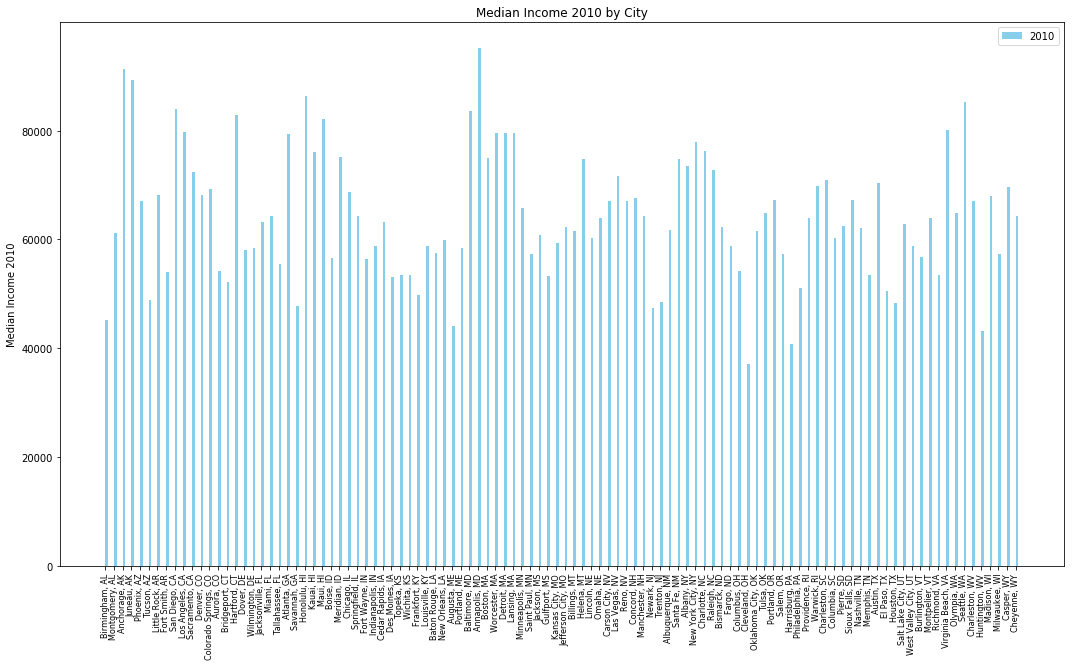

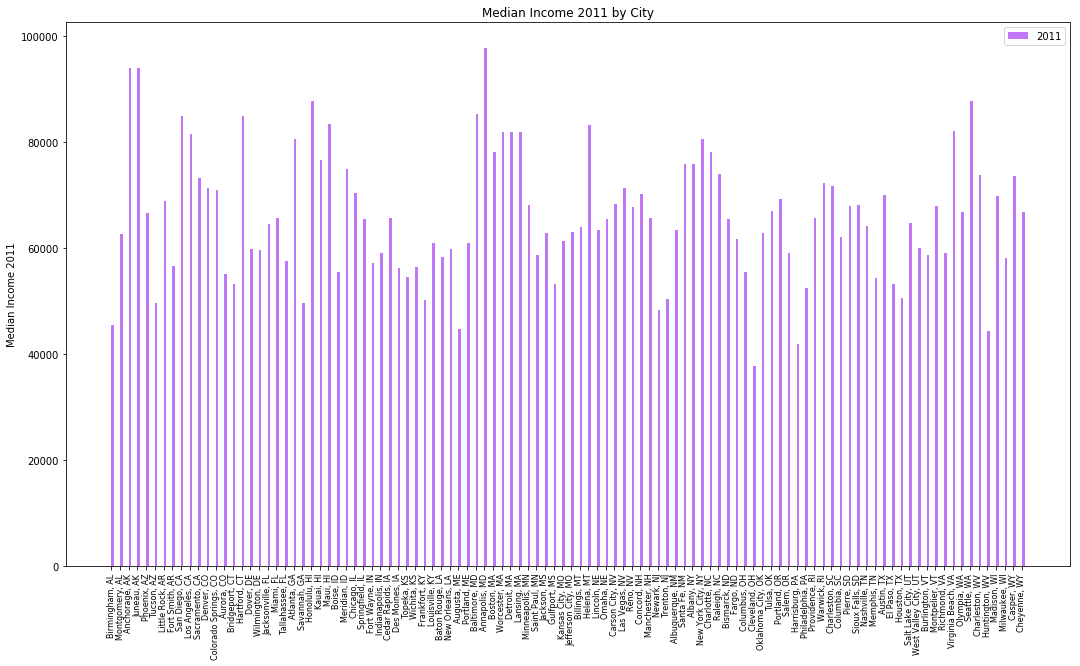

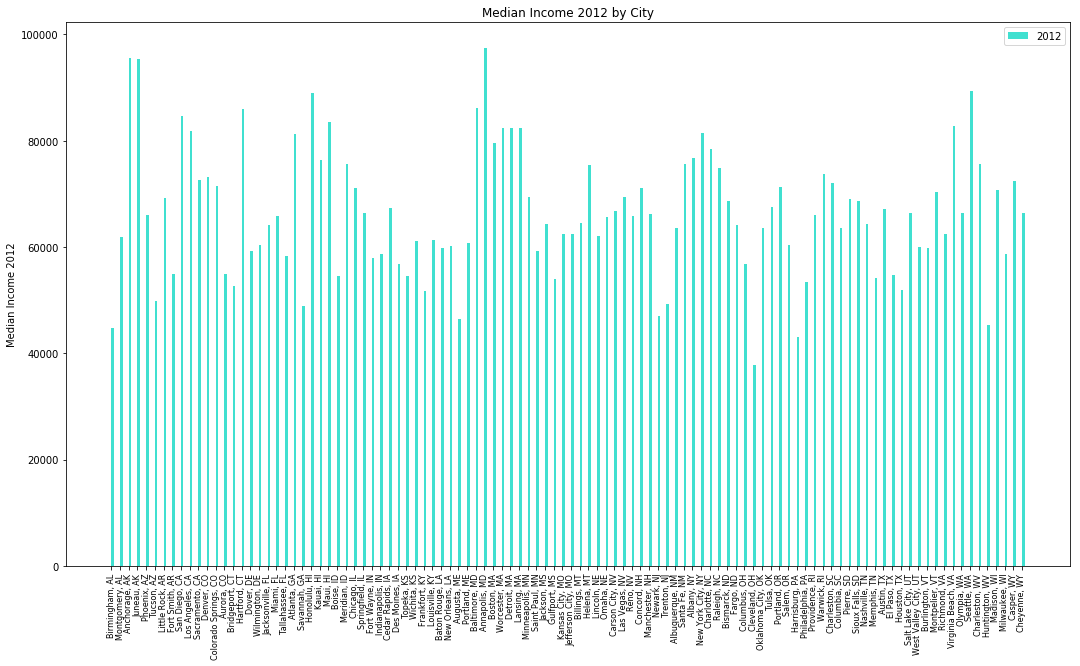

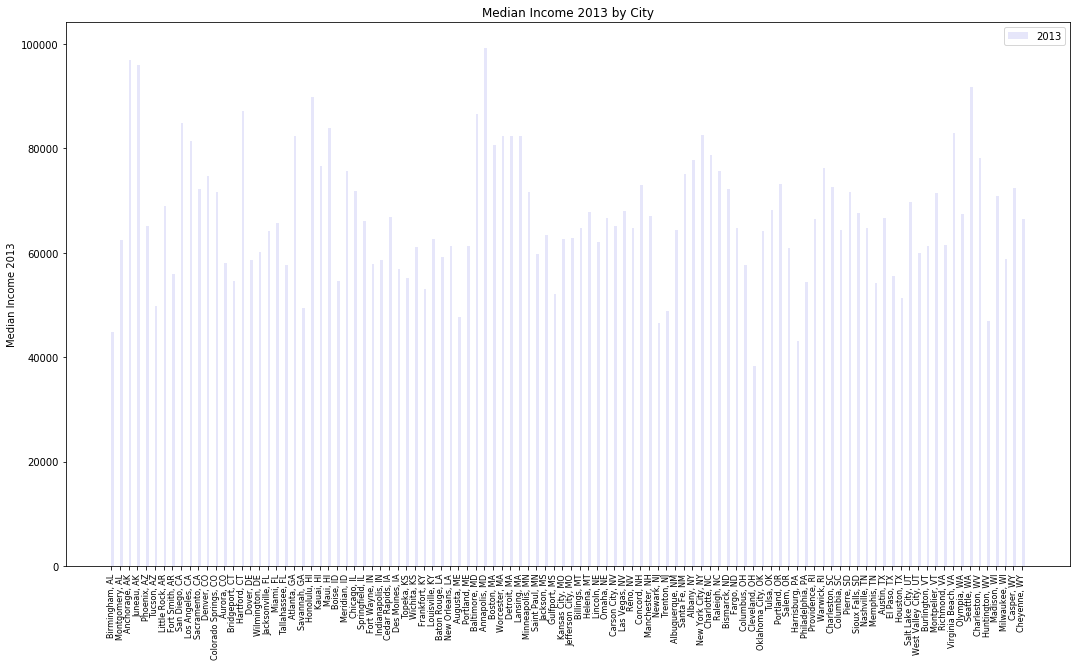

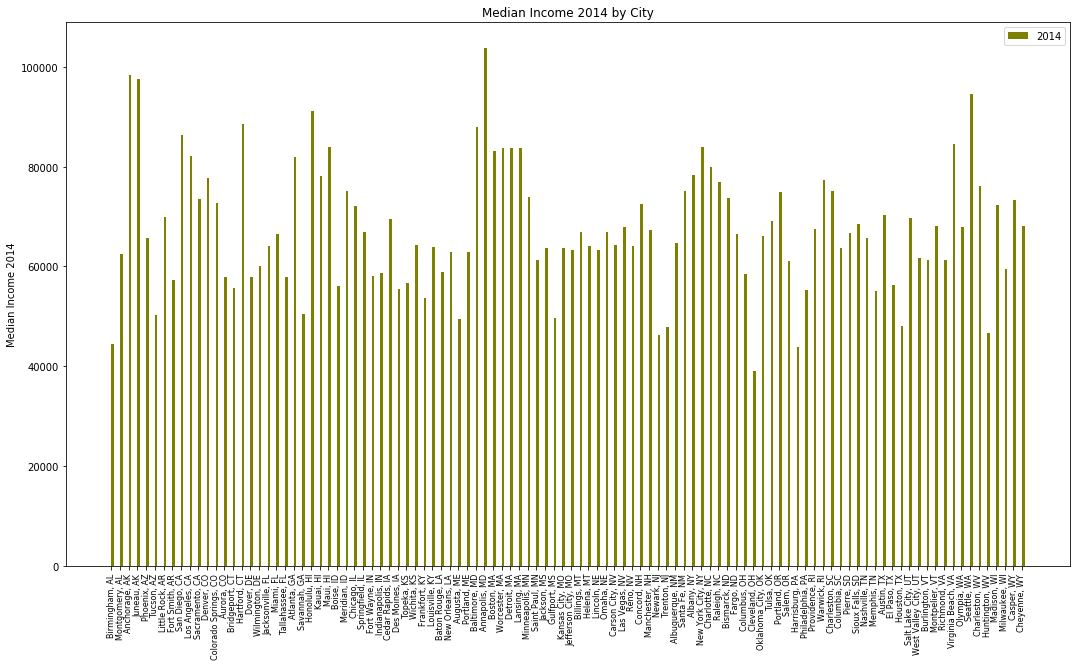

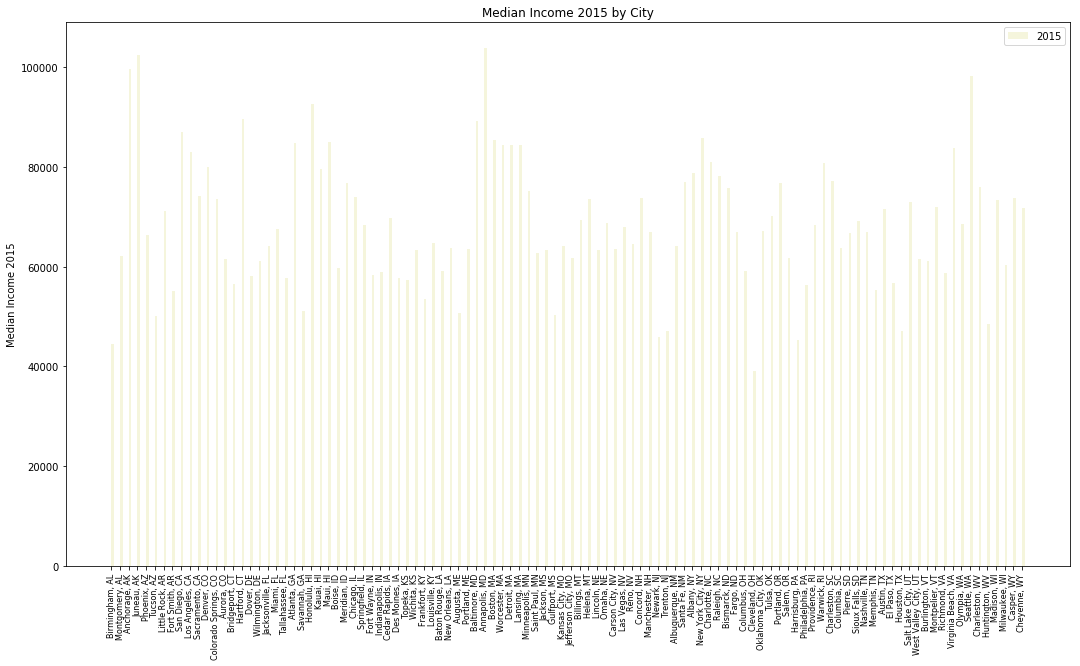

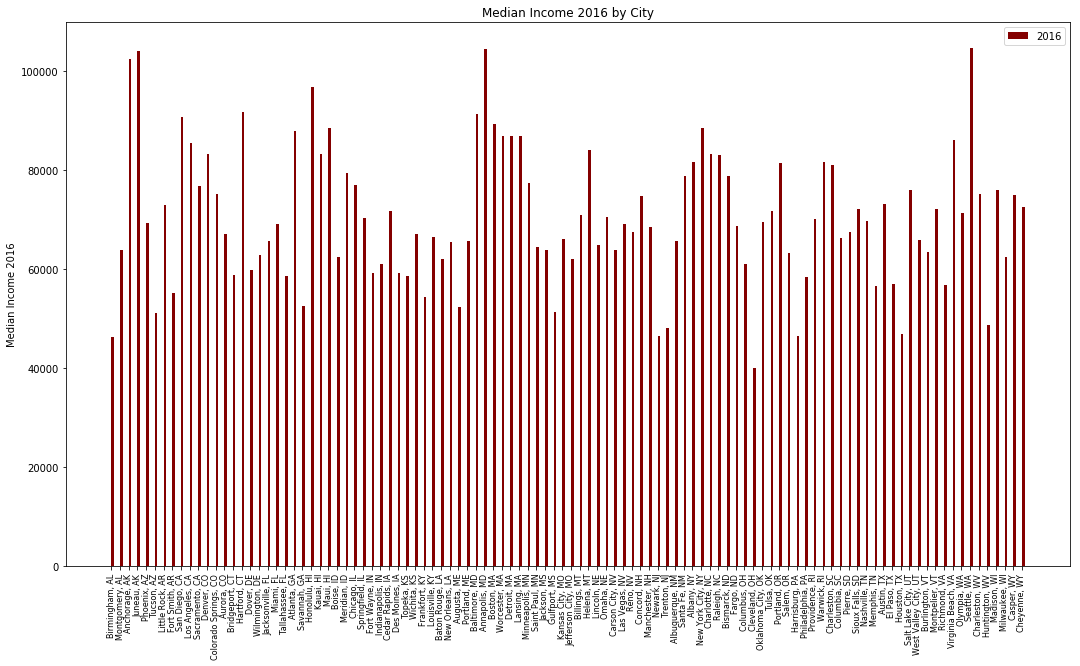

In [ ]:
# 2010

income2010 = income[['city', '2010']]
for index, value in enumerate(income2010['2010']):
    income2010['2010'][index] = float(value.replace(',',''))

ind = range(len(income2010['2010']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(income2010['2010'])), income2010['2010'], color='SkyBlue', align='edge', width=0.3, label='2010')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median Income 2010')
ax.set_title('Median Income 2010 by City')
ax.set_xticks(ind)
ax.set_xticklabels(income2010['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('income2010.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()



# 2011


income2011 = income[['city', '2011']]
income2011.head()
for index, value in enumerate(income2011['2011']):
    income2011['2011'][index] = float(value.replace(',',''))

ind = range(len(income2011['2011']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(income2011['2011'])), income2011['2011'], color='#bf77f6', align='edge', width=0.3, label='2011')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median Income 2011')
ax.set_title('Median Income 2011 by City')
ax.set_xticks(ind)
ax.set_xticklabels(income2011['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('income2011.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()


# 2012


income2012 = income[['city', '2012']]
income2012.head()
for index, value in enumerate(income2012['2012']):
    income2012['2012'][index] = float(value.replace(',',''))

ind = range(len(income2012['2012']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(income2012['2012'])), income2012['2012'], color='Turquoise', align='edge', width=0.3, label='2012')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median Income 2012')
ax.set_title('Median Income 2012 by City')
ax.set_xticks(ind)
ax.set_xticklabels(income2012['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('income2012.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()


# 2013


income2013 = income[['city', '2013']]
income2013.head()
for index, value in enumerate(income2013['2013']):
    income2013['2013'][index] = float(value.replace(',',''))

ind = range(len(income2013['2013']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(income2013['2013'])), income2013['2013'], color='Lavender', align='edge', width=0.3, label='2013')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median Income 2013')
ax.set_title('Median Income 2013 by City')
ax.set_xticks(ind)
ax.set_xticklabels(income2012['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('income2013.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()

# 2014


income2014 = income[['city', '2014']]
income2014.head()
for index, value in enumerate(income2014['2014']):
    income2014['2014'][index] = float(value.replace(',',''))

ind = range(len(income2014['2014']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(income2014['2014'])), income2014['2014'], color='Olive', align='edge', width=0.3, label='2014')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median Income 2014')
ax.set_title('Median Income 2014 by City')
ax.set_xticks(ind)
ax.set_xticklabels(income2012['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('income2014.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()


# 2015


income2015 = income[['city', '2015']]
income2015.head()
for index, value in enumerate(income2015['2015']):
    income2015['2015'][index] = float(value.replace(',',''))

ind = range(len(income2015['2015']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(income2015['2015'])), income2015['2015'], color='Beige', align='edge', width=0.3, label='2015')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median Income 2015')
ax.set_title('Median Income 2015 by City')
ax.set_xticks(ind)
ax.set_xticklabels(income2015['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('income2015.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()


# 2016

income2016 = income[['city', '2016']]
income2016.head()
for index, value in enumerate(income2016['2016']):
    income2016['2016'][index] = float(value.replace(',',''))

ind = range(len(income2016['2016']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(income2016['2016'])), income2016['2016'], color='#840000', align='edge', width=0.3, label='2016')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median Income 2016')
ax.set_title('Median Income 2016 by City')
ax.set_xticks(ind)
ax.set_xticklabels(income2016['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('income2016.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()

## Unemployment Rate Graphs 2010-2016

C:\Users\PokeDanny10\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


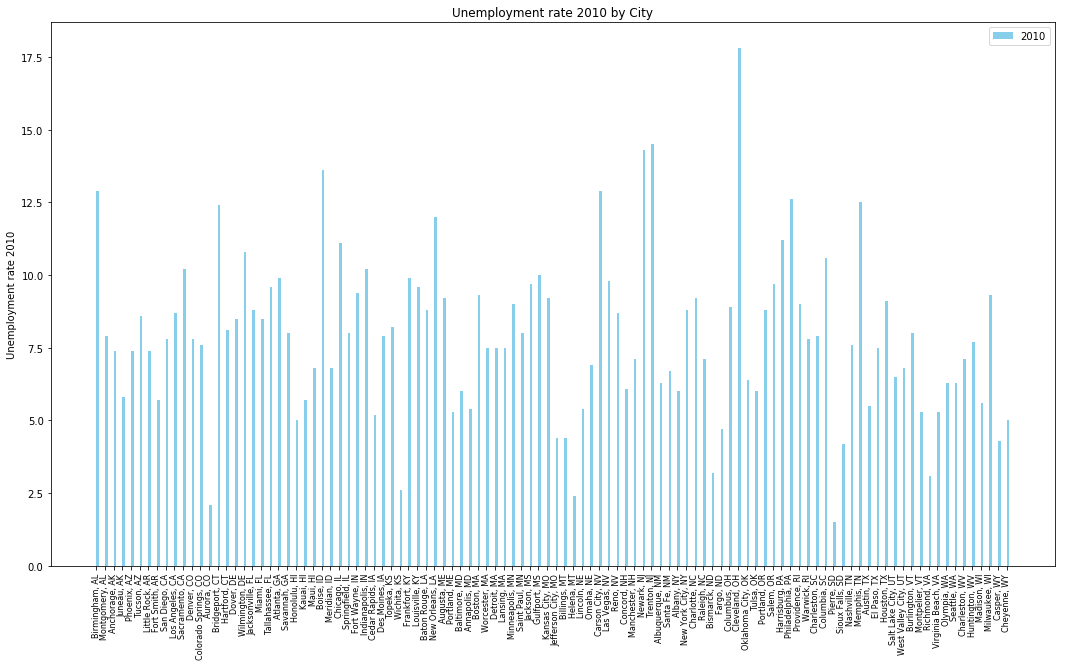

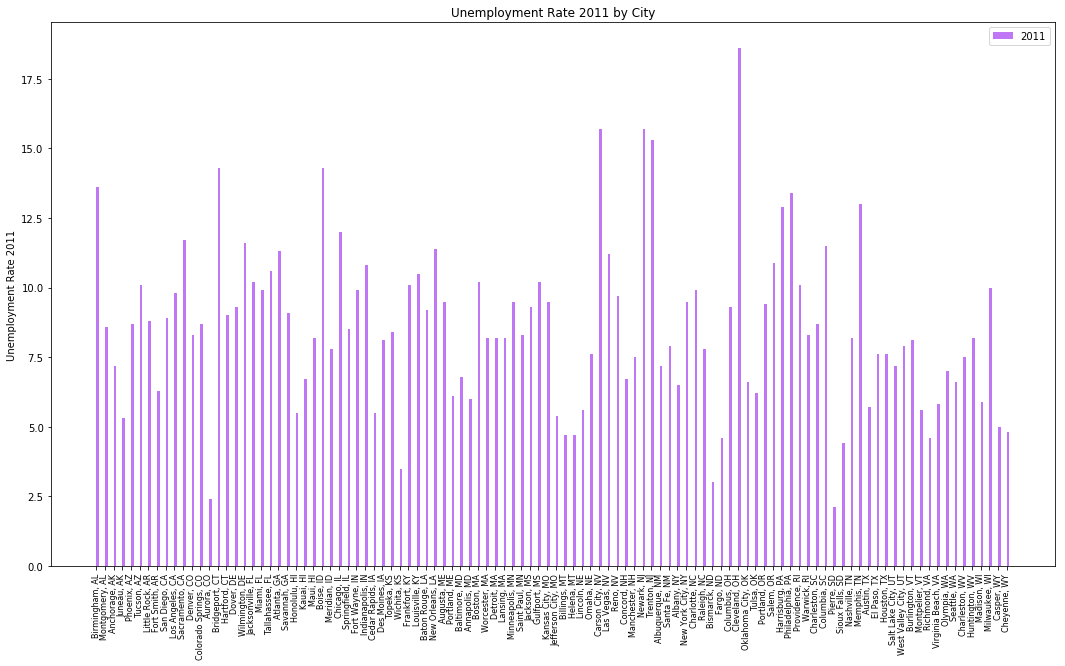

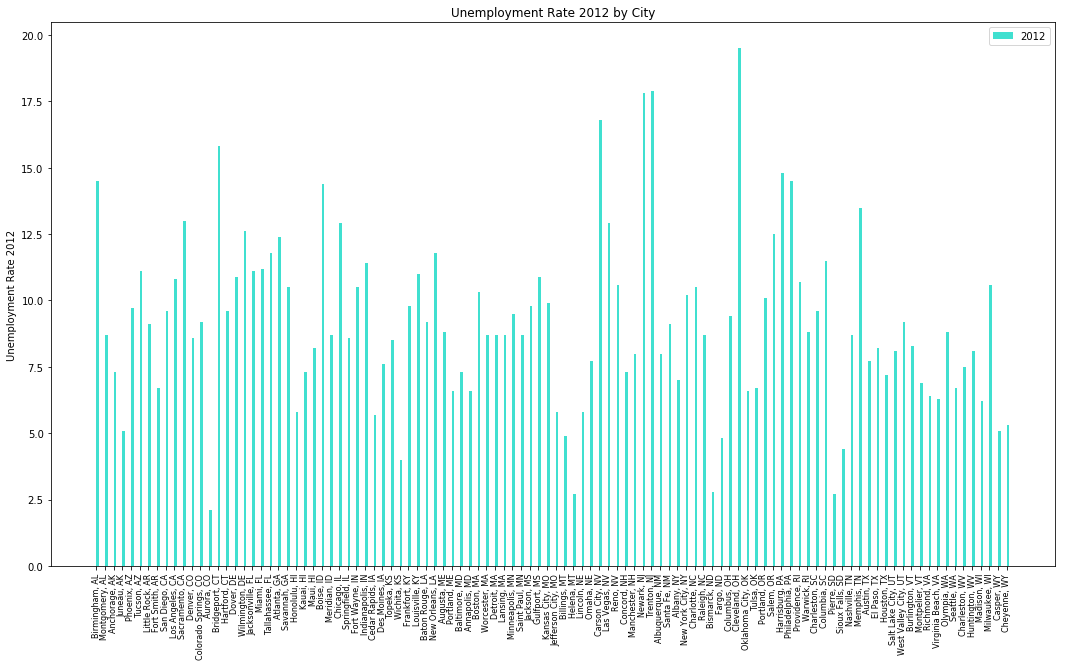

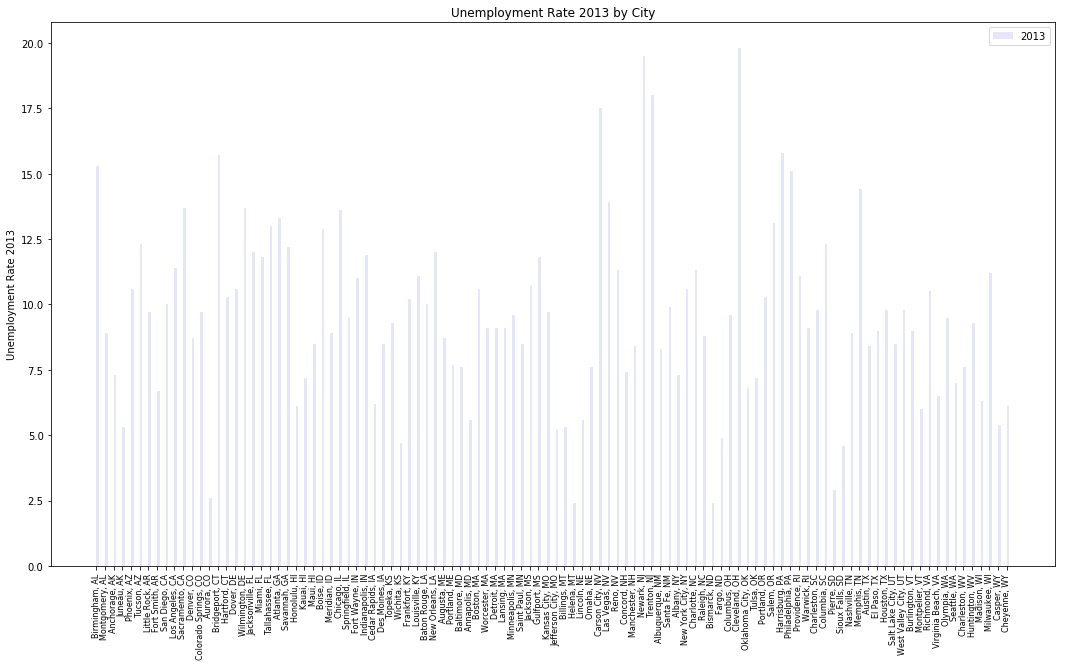

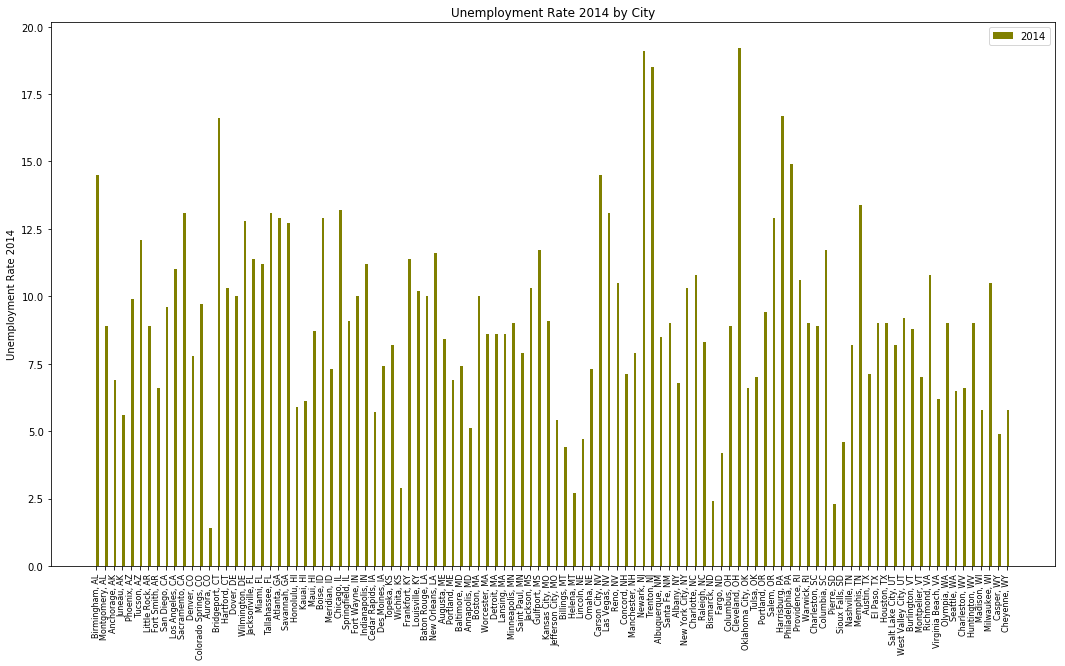

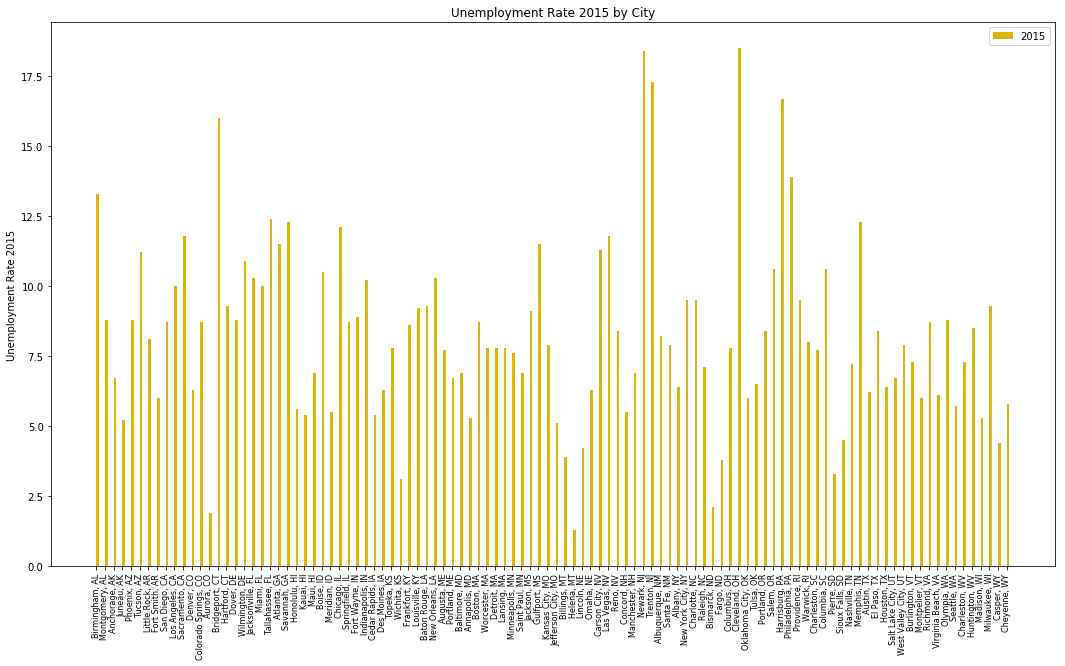

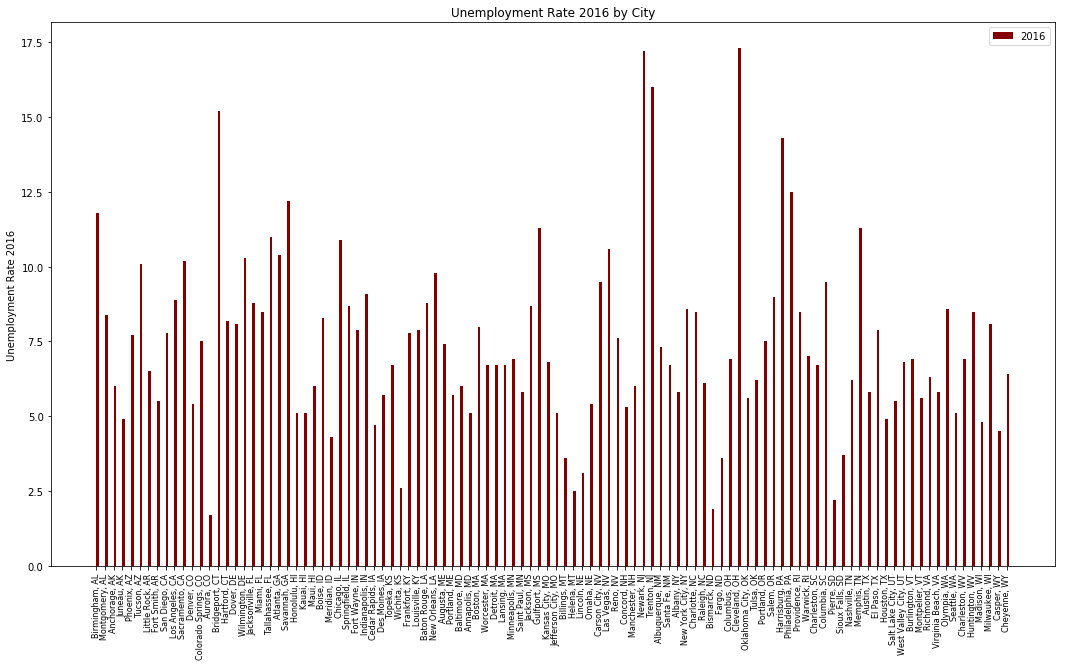

In [ ]:
#2010

unemployment2010 = unemployment[['city', '2010']]
unemployment2010.head()
for index, value in enumerate(unemployment2010['2010']):
    unemployment2010['2010'][index] = float(value.replace('%',''))

ind = range(len(unemployment2010['2010']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(unemployment2010['2010'])), unemployment2010['2010'], color='SkyBlue', align='edge', width=0.3, label='2010')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Unemployment rate 2010')
ax.set_title('Unemployment rate 2010 by City')
ax.set_xticks(ind)
ax.set_xticklabels(unemployment2010['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('unemployment2010.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()


#2011


unemployment2011 = unemployment[['city', '2011']]
unemployment2011.head()
for index, value in enumerate(unemployment2011['2011']):
    unemployment2011['2011'][index] = float(value.replace('%',''))

ind = range(len(unemployment2011['2011']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(unemployment2011['2011'])), unemployment2011['2011'], color='#bf77f6', align='edge', width=0.3, label='2011')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Unemployment Rate 2011')
ax.set_title('Unemployment Rate 2011 by City')
ax.set_xticks(ind)
ax.set_xticklabels(unemployment2011['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('unemployment2011.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()



#2012


unemployment2012 = unemployment[['city', '2012']]
unemployment2012.head()
for index, value in enumerate(unemployment2012['2012']):
    unemployment2012['2012'][index] = float(value.replace('%',''))

ind = range(len(unemployment2012['2012']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(unemployment2012['2012'])), unemployment2012['2012'], color='Turquoise', align='edge', width=0.3, label='2012')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Unemployment Rate 2012')
ax.set_title('Unemployment Rate 2012 by City')
ax.set_xticks(ind)
ax.set_xticklabels(unemployment2012['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('unemployment2012.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()

#2013


unemployment2013 = unemployment[['city', '2013']]
unemployment2013.head()
for index, value in enumerate(unemployment2013['2013']):
    unemployment2013['2013'][index] = float(value.replace('%',''))

ind = range(len(unemployment2013['2013']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(unemployment2013['2013'])), unemployment2013['2013'], color='Lavender', align='edge', width=0.3, label='2013')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Unemployment Rate 2013')
ax.set_title('Unemployment Rate 2013 by City')
ax.set_xticks(ind)
ax.set_xticklabels(unemployment2013['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('unemployment2013.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show

#2014


unemployment2014 = unemployment[['city', '2014']]
unemployment2014.head()
for index, value in enumerate(unemployment2014['2014']):
    unemployment2014['2014'][index] = float(value.replace('%',''))

ind = range(len(unemployment2014['2014']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(unemployment2014['2014'])), unemployment2014['2014'], color='Olive', align='edge', width=0.3, label='2014')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Unemployment Rate 2014')
ax.set_title('Unemployment Rate 2014 by City')
ax.set_xticks(ind)
ax.set_xticklabels(unemployment2014['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('unemployment2014.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()



#2015


unemployment2015 = unemployment[['city', '2015']]
unemployment2015.head()
for index, value in enumerate(unemployment2015['2015']):
    unemployment2015['2015'][index] = float(value.replace('%',''))

ind = range(len(unemployment2015['2015']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(unemployment2015['2015'])), unemployment2015['2015'], color='#dbb40c', align='edge', width=0.3, label='2015')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Unemployment Rate 2015')
ax.set_title('Unemployment Rate 2015 by City')
ax.set_xticks(ind)
ax.set_xticklabels(unemployment2015['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('unemployment2015.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()


#2016


unemployment2016 = unemployment[['city', '2016']]
unemployment2016.head()
for index, value in enumerate(unemployment2016['2016']):
    unemployment2016['2016'][index] = float(value.replace('%',''))

ind = range(len(unemployment2016['2016']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(unemployment2016['2016'])), unemployment2016['2016'], color='#840000', align='edge', width=0.3, label='2016')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Unemployment Rate 2016')
ax.set_title('Unemployment Rate 2016 by City')
ax.set_xticks(ind)
ax.set_xticklabels(unemployment2016['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('unemployment2016.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()

## Traffic Graphs 2010-2016

C:\Users\PokeDanny10\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\PokeDanny10\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


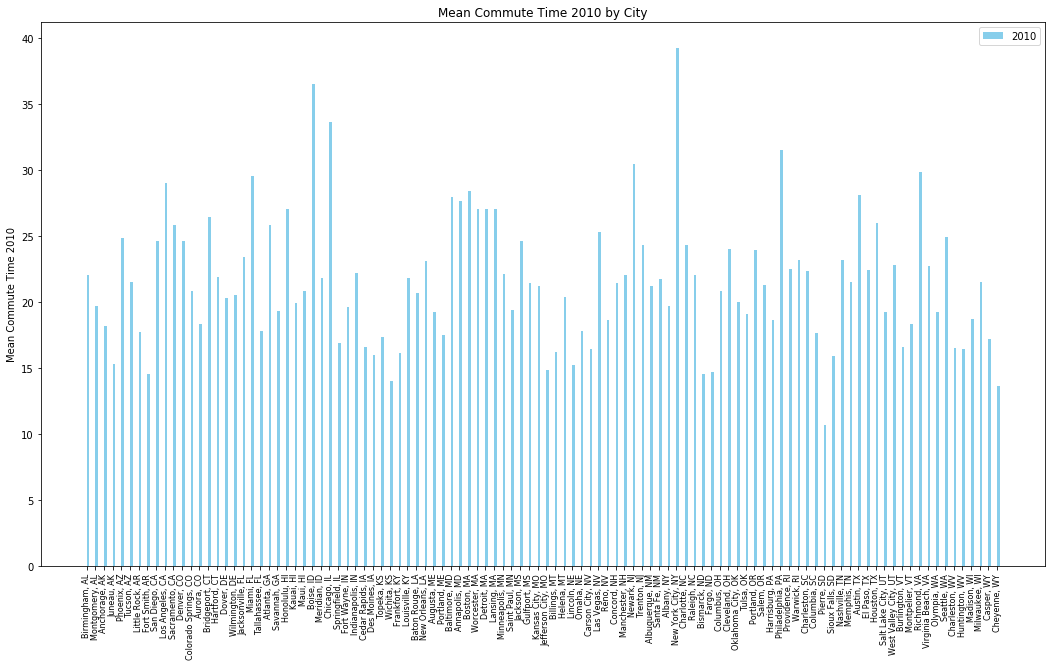

C:\Users\PokeDanny10\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


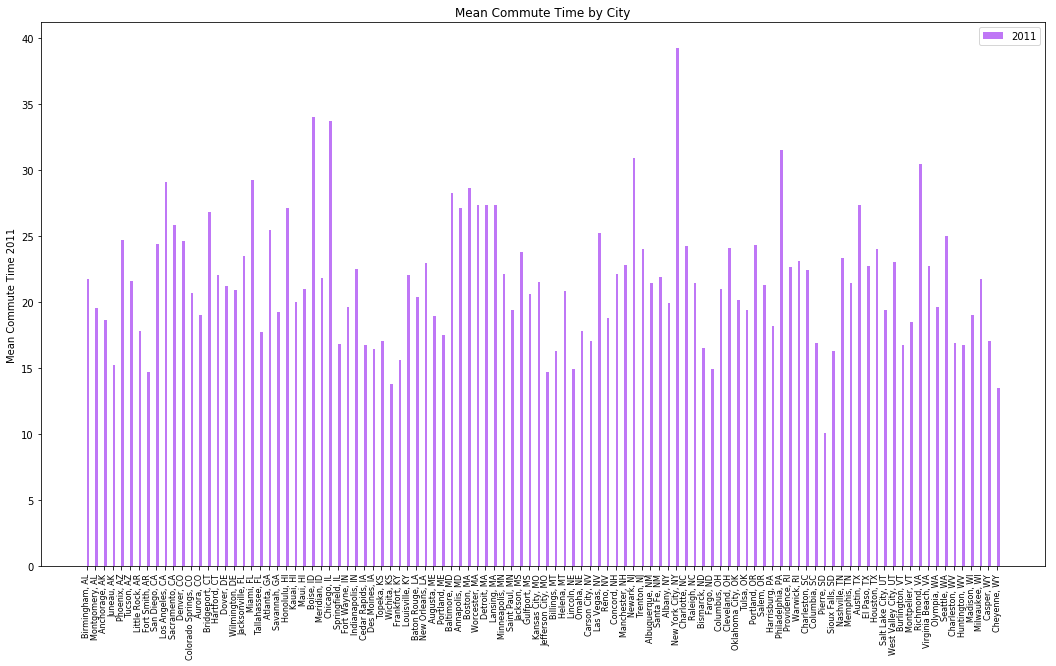

C:\Users\PokeDanny10\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


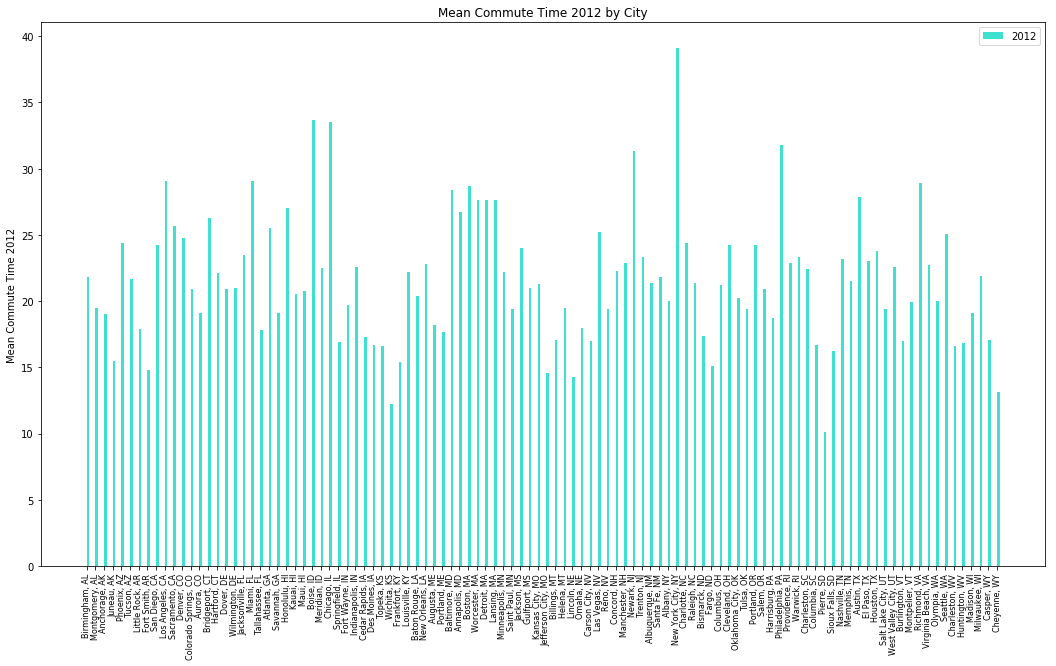

C:\Users\PokeDanny10\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


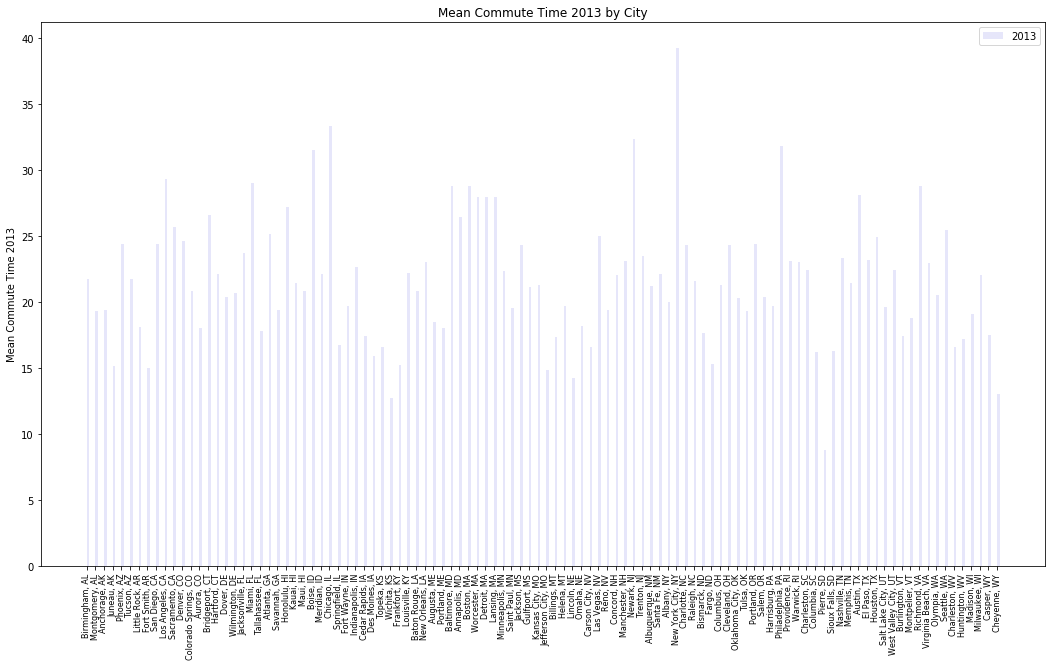

C:\Users\PokeDanny10\Anaconda3\lib\site-packages\ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


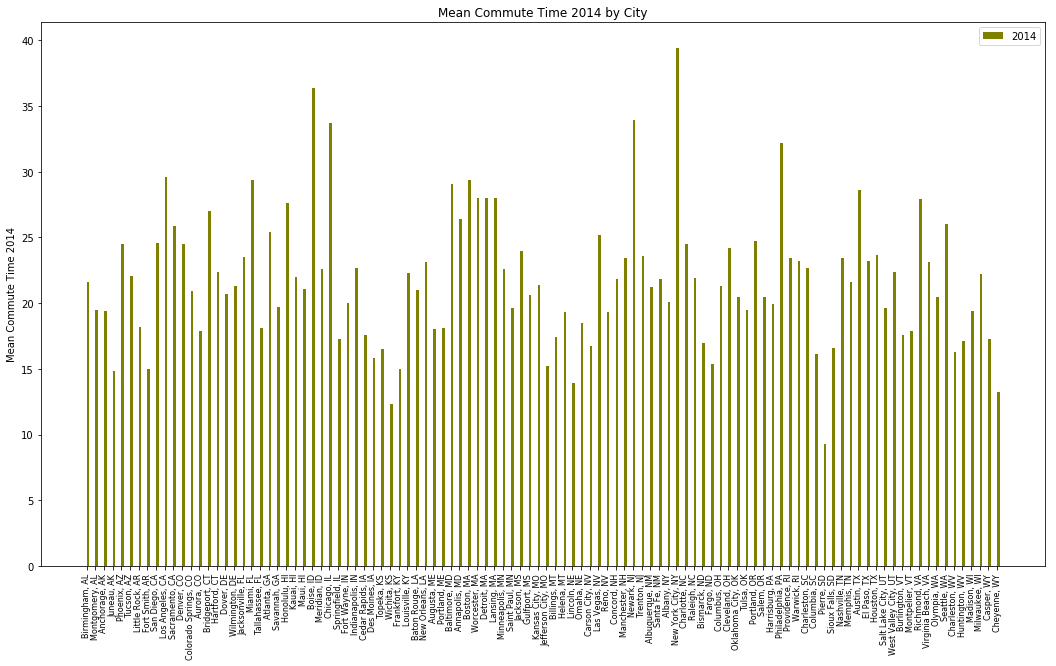

C:\Users\PokeDanny10\Anaconda3\lib\site-packages\ipykernel_launcher.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


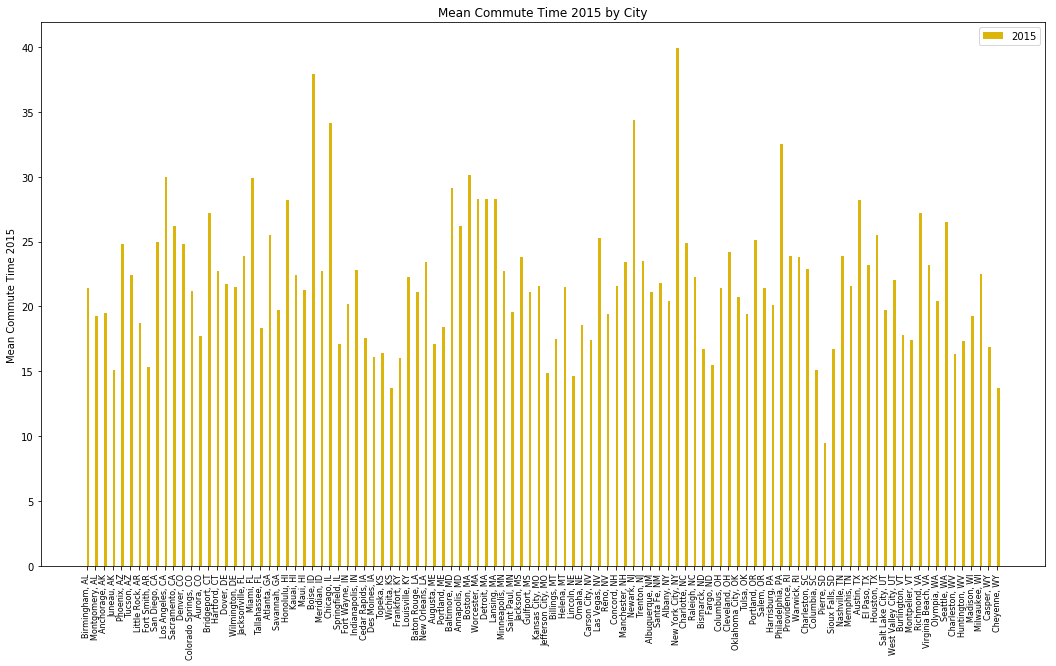

C:\Users\PokeDanny10\Anaconda3\lib\site-packages\ipykernel_launcher.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


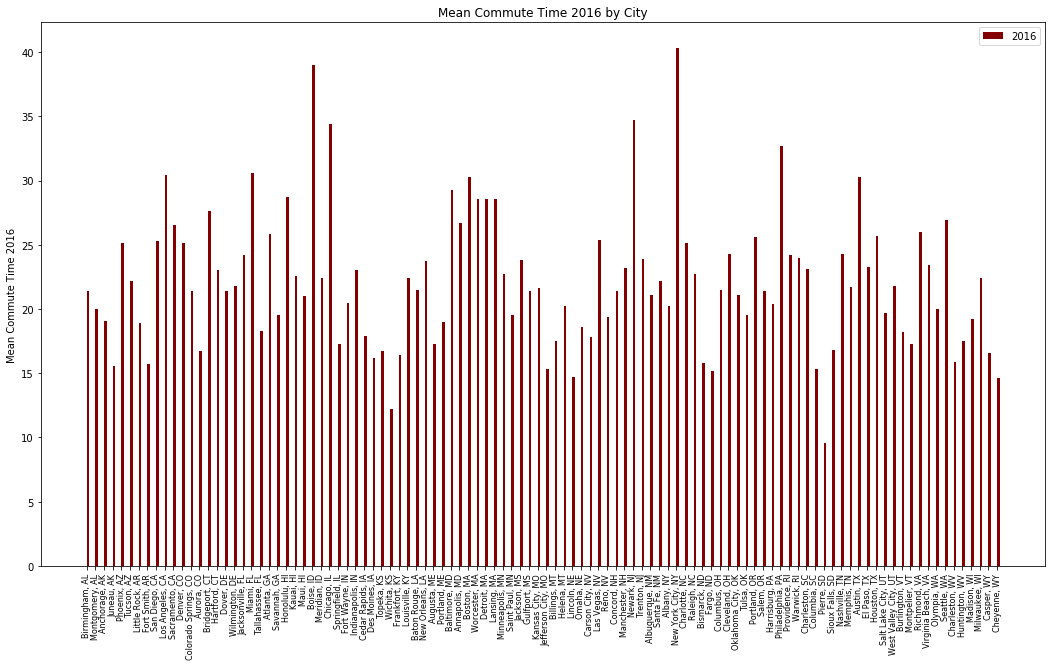

In [ ]:
#2010


traffic2010 = traffic[['city', '2010']]
traffic2010.head()
for index, value in enumerate(traffic2010['2010']):
    traffic2010['2010'][index] = float(value)

ind = range(len(traffic2010['2010']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(traffic2010['2010'])), traffic2010['2010'], color='SkyBlue', align='edge', width=0.3, label='2010')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Commute Time 2010')
ax.set_title('Mean Commute Time 2010 by City')
ax.set_xticks(ind)
ax.set_xticklabels(traffic2010['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('traffic2010.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()



#2011


traffic2011 = traffic[['city', '2011']]
traffic2011.head()
for index, value in enumerate(traffic2011['2011']):
    traffic2011['2011'][index] = float(value)

ind = range(len(traffic2011['2011']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(traffic2011['2011'])), traffic2011['2011'], color='#bf77f6', align='edge', width=0.3, label='2011')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Commute Time 2011')
ax.set_title('Mean Commute Time by City')
ax.set_xticks(ind)
ax.set_xticklabels(traffic2011['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('traffic2011.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()



#2012


traffic2012 = traffic[['city', '2012']]
traffic2012.head()
for index, value in enumerate(traffic2012['2012']):
    traffic2012['2012'][index] = float(value)

ind = range(len(traffic2012['2012']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(traffic2012['2012'])), traffic2012['2012'], color='Turquoise', align='edge', width=0.3, label='2012')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Commute Time 2012')
ax.set_title('Mean Commute Time 2012 by City')
ax.set_xticks(ind)
ax.set_xticklabels(traffic2012['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('traffic2012.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()



#2013


traffic2013 = traffic[['city', '2013']]
traffic2013.head()
for index, value in enumerate(traffic2013['2013']):
    traffic2013['2013'][index] = float(value)

ind = range(len(traffic2013['2013']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(traffic2013['2013'])), traffic2013['2013'], color='Lavender', align='edge', width=0.3, label='2013')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Commute Time 2013')
ax.set_title('Mean Commute Time 2013 by City')
ax.set_xticks(ind)
ax.set_xticklabels(traffic2013['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('traffic2013.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()


# 2014
traffic2014 = traffic[['city', '2014']]
traffic2014.head()
for index, value in enumerate(traffic2014['2014']):
    traffic2014['2014'][index] = float(value)

ind = range(len(traffic2014['2014']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(traffic2014['2014'])), traffic2014['2014'], color='Olive', align='edge', width=0.3, label='2014')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Commute Time 2014')
ax.set_title('Mean Commute Time 2014 by City')
ax.set_xticks(ind)
ax.set_xticklabels(traffic2014['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('traffic2014.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()


#2015

traffic2015 = traffic[['city', '2015']]
traffic2015.head()
for index, value in enumerate(traffic2015['2015']):
    traffic2015['2015'][index] = float(value)

ind = range(len(traffic2015['2015']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(traffic2015['2015'])), traffic2015['2015'], color='#dbb40c', align='edge', width=0.3, label='2015')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Commute Time 2015')
ax.set_title('Mean Commute Time 2015 by City')
ax.set_xticks(ind)
ax.set_xticklabels(traffic2015['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('traffic2015.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()


#2016

traffic2016 = traffic[['city', '2016']]
for index, value in enumerate(traffic2016['2016']):
    traffic2016['2016'][index] = float(value)

ind = range(len(traffic2016['2016']))  # the x locations for the groups

fig, ax = plt.subplots()
rects1 = ax.bar(range(len(traffic2016['2016'])), traffic2016['2016'], color='#840000', align='edge', width=0.3, label='2016')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Commute Time 2016')
ax.set_title('Mean Commute Time 2016 by City')
ax.set_xticks(ind)
ax.set_xticklabels(traffic2016['city'], rotation='vertical', fontsize=8)
ax.legend()

fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.savefig('traffic2016.png', dpi=100)
fig.set_size_inches(18, 10, forward=True)

plt.show()

## Crime Graphs 2010-2016

Due to the fact that we have many many crimes to look at, I'll be aggregating annual crime rates across the country per type of crime.

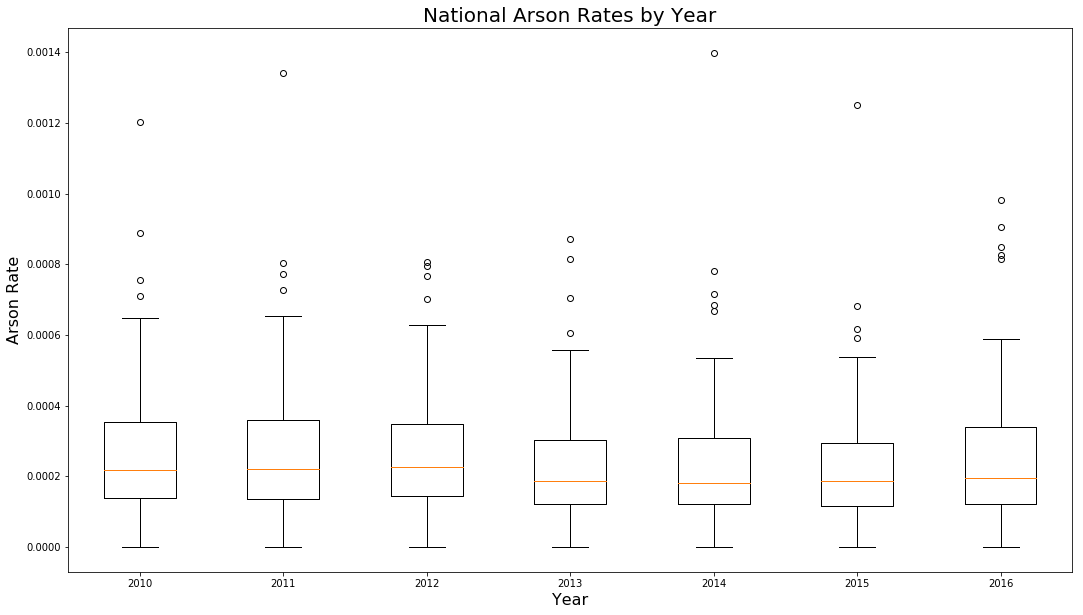

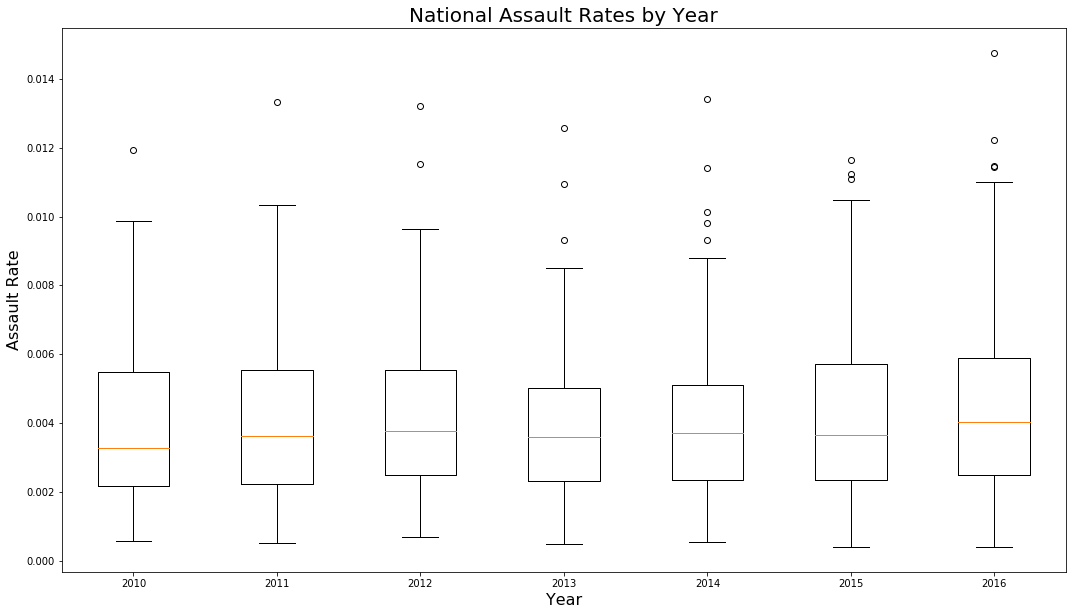

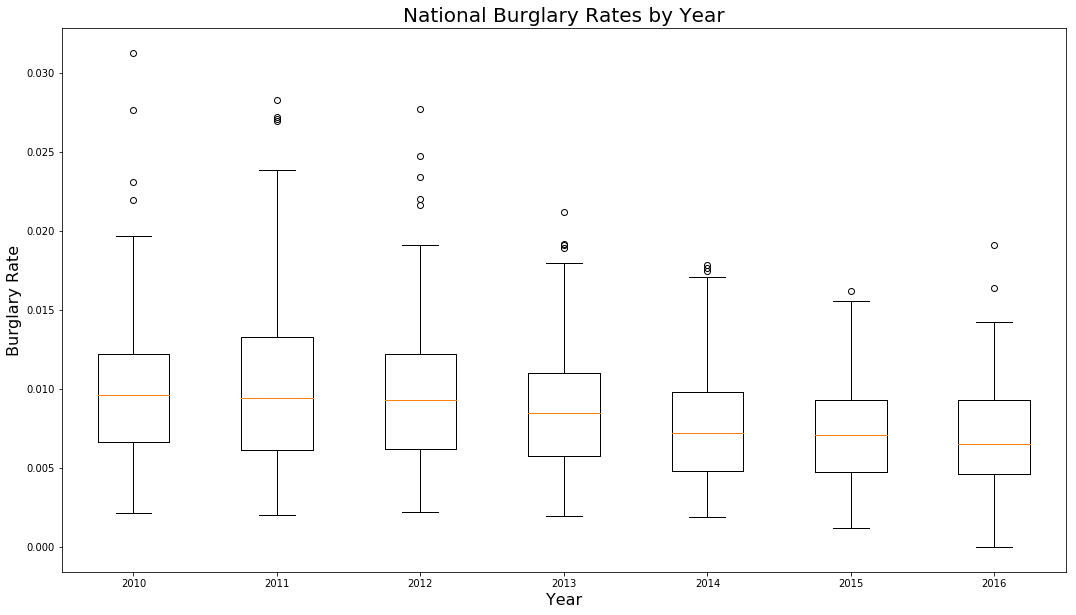

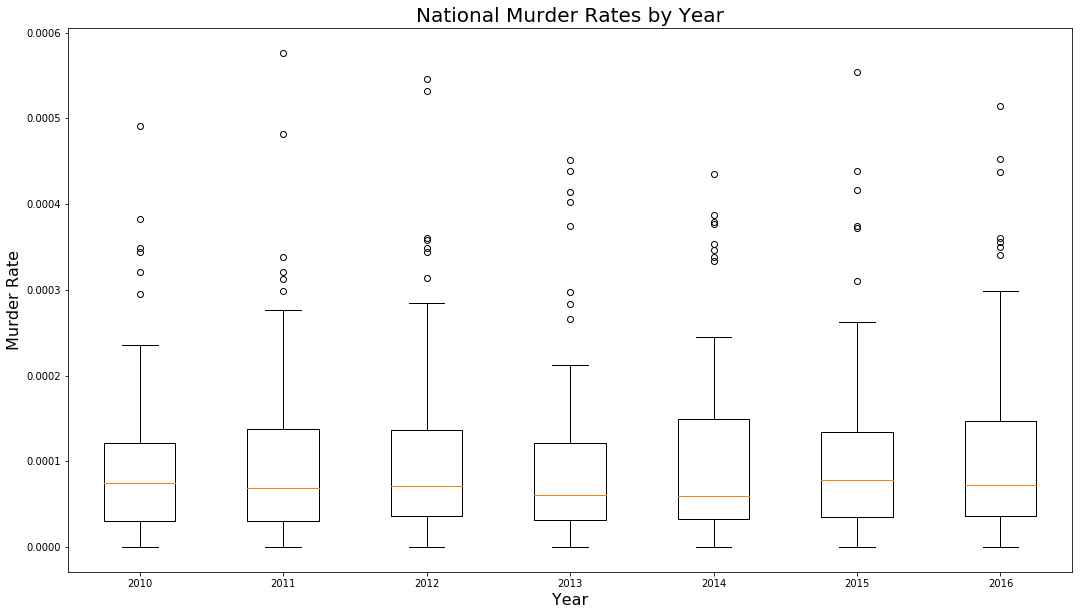

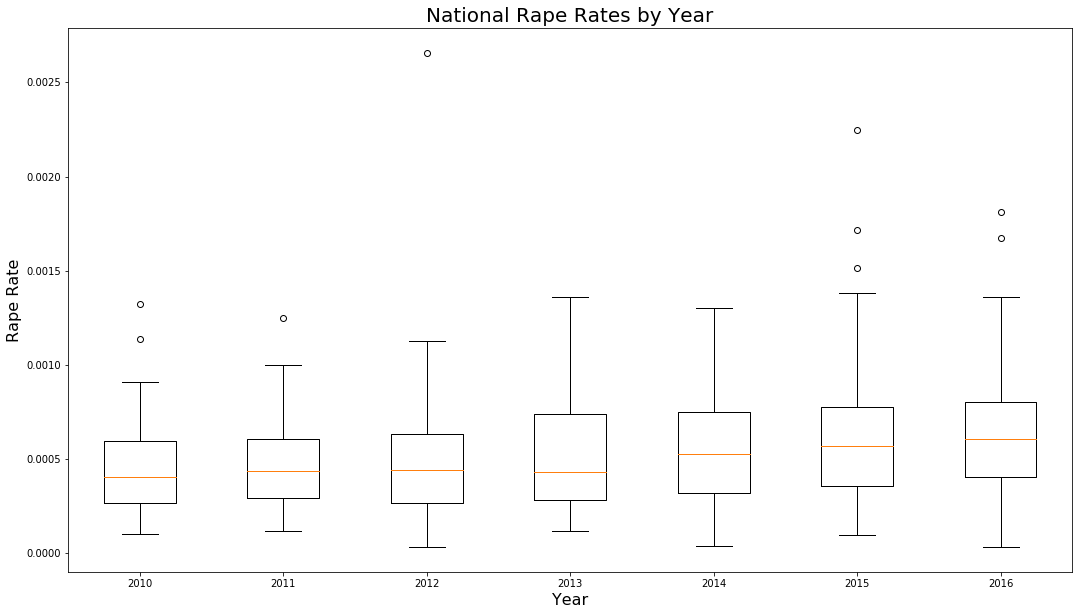

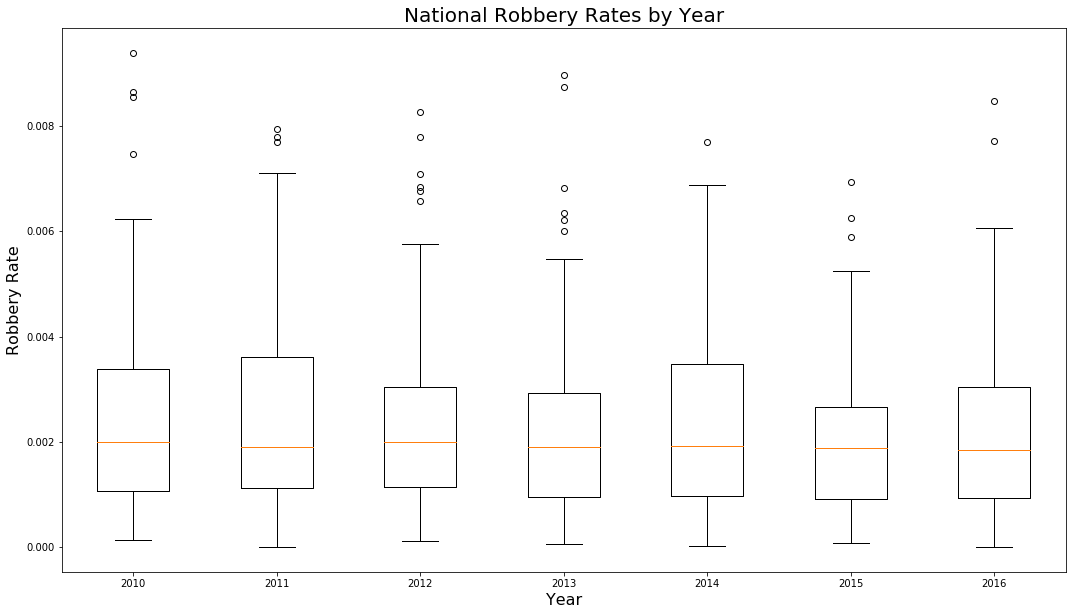

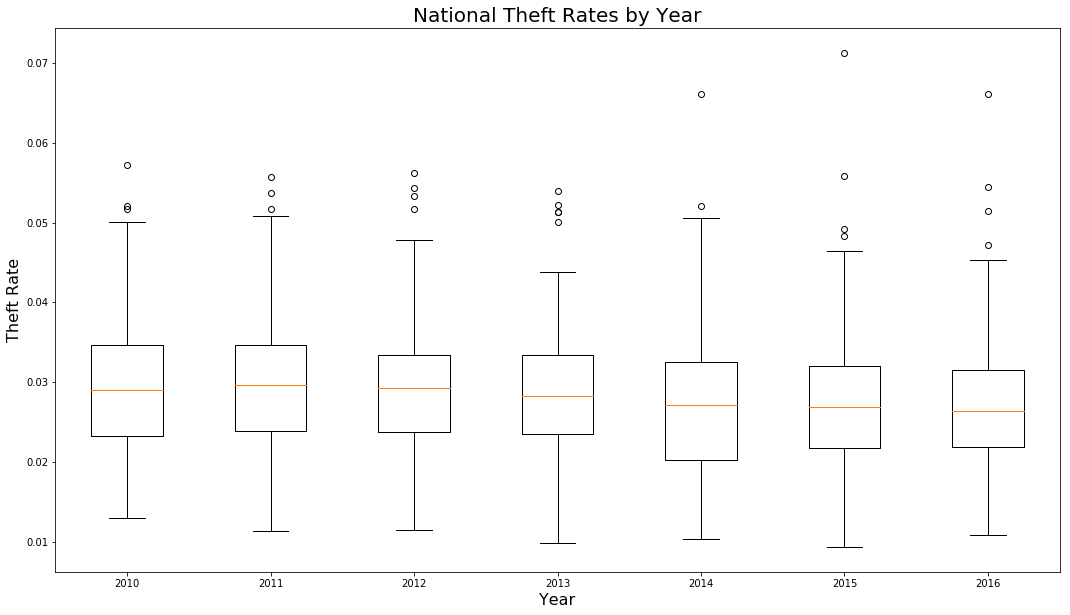

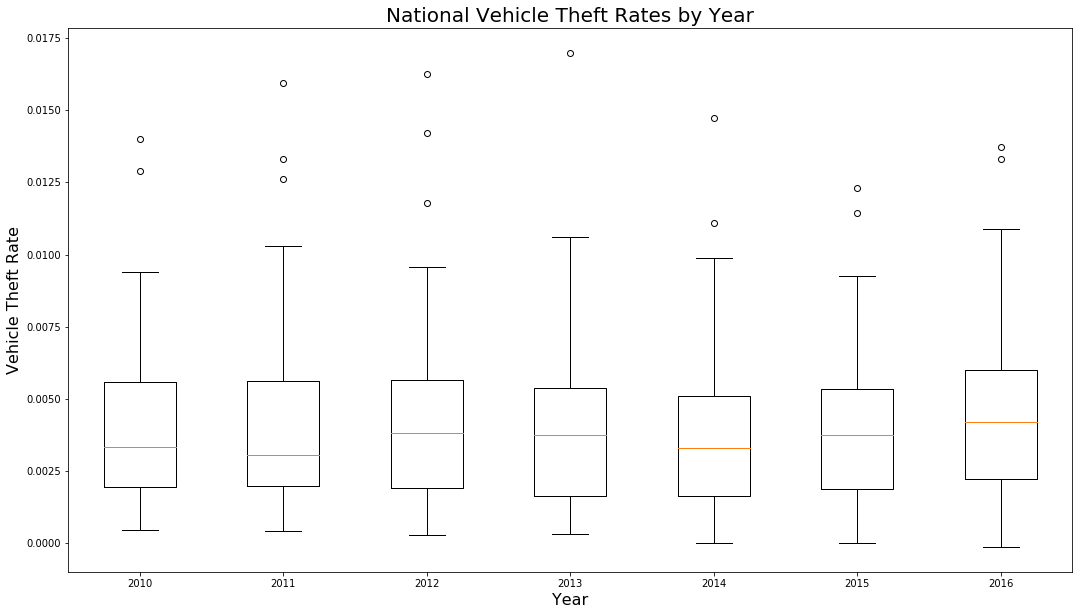

In [ ]:
years = [str(year) for year in range(2010, 2016+1)]

# A+ variable naming
crime_by_crime = crime.reset_index().drop('city', axis='columns').set_index('year').transpose()

for crime_name in crime_by_crime.index:
    crime_rates = crime_by_crime.loc[crime_name]
    fig, ax = plt.subplots()
    ax.boxplot([crime_rates[year].values for year in years],
               labels=years)
    ax.set_title("National {}s by Year".format(crime_name.title()), fontsize=20)
    ax.set_xlabel("Year", fontsize=16)
    ax.set_ylabel(crime_name.title(), fontsize=16)
    fig = plt.gcf()
    fig.set_size_inches(18, 10)

# Data Analysis and Results

In [ ]:
from sklearn.linear_model import LinearRegression as sk_LinearRegression

## Calculate Multiple Correlation Coefficient

Only looking at the years for which we have happiness data.

Methodology from [Wikipedia](https://en.wikipedia.org/wiki/Multiple_correlation#Computation).

Let $R$ denote the coefficient of multiple correlation:  
"the Pearson correlation coefficient between the predicted and the actual values of the dependent variable in a linear regression model".

![GitHub doesn't like LaTeX I guess](pearson.png)

In [ ]:
c = data.dropna().corr().values[:-1,[-1]]
display(data.dropna().corr().drop('happiness', axis='index')['happiness'])

median income         0.133706
unemployment rate    -0.353547
mean commute time    -0.016936
arson rate           -0.237336
assault rate         -0.386573
burglary rate        -0.448112
murder rate          -0.477110
rape rate             0.066838
robbery rate         -0.519190
theft rate           -0.152628
vehicle theft rate   -0.231527
Name: happiness, dtype: float64

None of our variables individually are particularly strongly correlated with happiness.

In [ ]:
R_xx = data.dropna().corr().values[:-1,:-1]
display(data.dropna().corr().drop('happiness', axis='index').drop('happiness', axis='columns'))

,median income,unemployment rate,mean commute time,arson rate,assault rate,burglary rate,murder rate,rape rate,robbery rate,theft rate,vehicle theft rate
median income,1.000000,-0.505509,0.167971,-0.278277,-0.185433,-0.375989,-0.293157,-0.225765,-0.311808,-0.082478,-0.110416
unemployment rate,-0.505509,1.000000,0.305801,0.173044,0.153827,0.215680,0.373287,-0.029590,0.464963,-0.173906,0.142741
mean commute time,0.167971,0.305801,1.000000,-0.153104,-0.211207,-0.305332,0.070645,-0.346578,0.091533,-0.434058,-0.110841
arson rate,-0.278277,0.173044,-0.153104,1.000000,0.273050,0.540993,0.373815,0.319267,0.425747,0.206279,0.336884
assault rate,-0.185433,0.153827,-0.211207,0.273050,1.000000,0.650798,0.537761,0.269691,0.649698,0.357756,0.451951
burglary rate,-0.375989,0.215680,-0.305332,0.540993,0.650798,1.000000,0.520745,0.359638,0.647872,0.513332,0.544436
murder rate,-0.293157,0.373287,0.070645,0.373815,0.537761,0.520745,1.000000,0.125618,0.795926,0.063153,0.410735
rape rate,-0.225765,-0.029590,-0.346578,0.319267,0.269691,0.359638,0.125618,1.000000,0.175994,0.399257,0.313619
robbery rate,-0.311808,0.464963,0.091533,0.425747,0.649698,0.647872,0.795926,0.175994,1.000000,0.152506,0.575022
theft rate,-0.082478,-0.173906,-0.434058,0.206279,0.357756,0.513332,0.063153,0.399257,0.152506,1.000000,0.391938


The strongest pairwise correlation between the metrics is murder and robbery ($r=0.795926$).  
The second-strongest is between burglary and assault ($r=0.650798$).

In [ ]:
R = np.sqrt(c.T @ np.linalg.inv(R_xx) @ c)
print(R[0,0])

0.6367905578342211


$R=0.636790557834221$

Our metrics do a better-than-chance job of predicting happiness!

## Fit a Regression Model to Available Happiness Data

In [ ]:
# years for which we have happiness data
X_available = data.values[~np.isnan(data.values[:,-1])][:,:-1]
y_available = data.values[~np.isnan(data.values[:,-1])][:,[-1]]

In [ ]:
model = sk_LinearRegression().fit(X_available, y_available)

This makes an assumption that years are independent

In [ ]:
print("coefficients:\n{}".format(model.coef_[0]))
print("intercept:\n{}".format(model.intercept_[0]))

coefficients:
[-3.50471158e-05 -2.17731622e+01  4.12652456e-02 -8.04469628e+01
 -1.62513781e+01 -1.76423165e+02 -3.79872080e+03  1.69499512e+03
 -2.99652361e+02 -3.06937178e+01  1.22116685e+02]
intercept:
66.78267223412378


$
\begin{array}{l r l l}
    \textrm{happiness}_\textrm{predicted}=&&66.78267223412386\\
        &-&3.50471158\times10^{-5}&\times\;\textrm{median income}\\
        &-&2.17731622\times10^{1}&\times\;\textrm{unemployment rate}\\
        &+&4.12652456\times10^{-2}&\times\;\textrm{mean commute time}\\
        &-&8.04469628\times10^{2}&\times\;\textrm{arson rate}\\
        &-&1.62513781\times10^{1}&\times\;\textrm{assault rate}\\
        &-&1.76423165\times10^{2}&\times\;\textrm{burglary rate}\\
        &-&3.79872080\times10^{3}&\times\;\textrm{murder rate}\\
        &+&1.69499512\times10^{3}&\times\;\textrm{rape rate}\\
        &-&2.99652361\times10^{2}&\times\;\textrm{robbery rate}\\
        &-&3.06937178\times10^{1}&\times\;\textrm{theft rate}\\
        &+&1.22116685\times10^{2}&\times\;\textrm{vehicular theft rate}\\
\end{array}
$

In [ ]:
print("R^2:\n{}".format(model.score(X_available, y_available)))

R^2:
0.40550221454681823


$
R^2=0.4055022145468181
$

So I didn't realize this beforehand, but it turns out that the coefficient of determination $R^2$ for a simple linear model *is actually* just Pearson's $R$, squared.

Unfortunately, it appears that our regression model performs rather poorly, but $R^2$ is not a definitive measure of the model's goodness of fit. Yet it is difficult to draw a more robust, data-informed interpretation due to the high dimensionality of our data.

Also somewhat disturbingly, there is a rather high positive coefficient attached to the rape rate ($+1694.99512$). In other words, our model predicts that cities with higher rates of violent rape have a palpably higher happiness rating. One plausible explanation is that in cities with good standards of living, sexual assault *is reported more often*, while rape in less fortunate cities may go unreported or ignored by law enforcement. Consequentially, this could lead to a counterintuitive bias in our data. But keeping in mind the $R^2$ value we obtained, this is more or less a shot in the dark, so to speak.

It is also worth noting that the rape rate, on its own, had one of the weakest correlations with happiness ($+0.066838$). With this in mind, it could simply be that rape rates are so low in each city that it naturally has to be scaled by a large factor to influence the model at all.

I am very uncomfortable with the term "rape rate".

There is also a rather high positive coefficient for the vehicular theft rate ($+122.116685$). Perhaps nicer cities have nicer cars worth stealing?

## Apply Regression Model to Predict Missing Happiness Data

In [ ]:
data.head()

median income  unemployment rate  mean commute time  \
city       year                                                        
Albany, NY 2010        73470.0              0.060               19.7   
           2011        75821.0              0.065               19.9   
           2012        76707.0              0.070               20.0   
           2013        77687.0              0.073               20.0   
           2014        78285.0              0.068               20.1   

                 arson rate  assault rate  burglary rate  murder rate  \
city       year                                                         
Albany, NY 2010    0.000173      0.006698       0.009988     0.000022   
           2011    0.000122      0.005921       0.009105     0.000041   
           2012    0.000109      0.005153       0.009034     0.000041   
           2013    0.000126      0.005370       0.007197     0.000082   
           2014    0.000122      0.005102       0.006927     0.000081   

                 rape rate  robbery rate  theft rate  vehicle theft rate  \
city       year                                                            
Albany, NY 2010   0.000453      0.003408    0.037621            0.002470   
           2011   0.000336      0.003255    0.035749            0.002055   
           2012   0.000438      0.002536    0.033599            0.001568   
           2013   0.000306      0.002317    0.033107            0.001450   
           2014   0.000548      0.002404    0.031269            0.001237   

                 happiness  
city       year             
Albany, NY 2010        NaN  
           2011        NaN  
           2012        NaN  
           2013        NaN  
           2014       59.2

In [ ]:
def predict_happiness(row):
    if not np.isnan(row['happiness']):
        return row['happiness']
    else:
        return model.predict(row.values[:-1].reshape((1,-1)))[0][0]
data['happiness'] = data.apply(predict_happiness, axis='columns')

In [ ]:
data.head()

median income  unemployment rate  mean commute time  \
city       year                                                        
Albany, NY 2010        73470.0              0.060               19.7   
           2011        75821.0              0.065               19.9   
           2012        76707.0              0.070               20.0   
           2013        77687.0              0.073               20.0   
           2014        78285.0              0.068               20.1   

                 arson rate  assault rate  burglary rate  murder rate  \
city       year                                                         
Albany, NY 2010    0.000173      0.006698       0.009988     0.000022   
           2011    0.000122      0.005921       0.009105     0.000041   
           2012    0.000109      0.005153       0.009034     0.000041   
           2013    0.000126      0.005370       0.007197     0.000082   
           2014    0.000122      0.005102       0.006927     0.000081   

                 rape rate  robbery rate  theft rate  vehicle theft rate  \
city       year                                                            
Albany, NY 2010   0.000453      0.003408    0.037621            0.002470   
           2011   0.000336      0.003255    0.035749            0.002055   
           2012   0.000438      0.002536    0.033599            0.001568   
           2013   0.000306      0.002317    0.033107            0.001450   
           2014   0.000548      0.002404    0.031269            0.001237   

                 happiness  
city       year             
Albany, NY 2010  60.640942  
           2011  60.411513  
           2012  60.697082  
           2013  60.604010  
           2014  59.200000

## Find Each Year's Happiest City!

In [ ]:
yearly_happiness = data.reset_index()                 \
                       .sort_values(['year', 'city']) \
                       .set_index(['year', 'city'])   \
                       ['happiness']
yearly_happiness.head()

year  city           
2010  Albany, NY         60.640942
      Albuquerque, NM    62.087295
      Anchorage, AK      62.242175
      Annapolis, MD      61.260892
      Atlanta, GA        58.707013
Name: happiness, dtype: float64

In [ ]:
for year in [str(year) for year in range(2010, 2016+1)]:
    print("Happiest city of {year}:\n\t{city} with a score of {score:.2f}\n\tout of {num_cities} cities"
          .format(year=year,
                  city=yearly_happiness.loc[year].idxmax(),
                  score=yearly_happiness.loc[year].max(),
                  num_cities=len(yearly_happiness.loc[year].values)))

Happiest city of 2010:
	Helena, MT with a score of 64.37
	out of 93 cities
Happiest city of 2011:
	Aurora, CO with a score of 63.98
	out of 94 cities
Happiest city of 2012:
	Helena, MT with a score of 64.15
	out of 91 cities
Happiest city of 2013:
	Pierre, SD with a score of 64.30
	out of 90 cities
Happiest city of 2014:
	Anchorage, AK with a score of 65.70
	out of 90 cities
Happiest city of 2015:
	Honolulu, HI with a score of 66.20
	out of 89 cities
Happiest city of 2016:
	Honolulu, HI with a score of 68.00
	out of 91 cities


Keep in mind that we predicted happiness values for all of 2010, 2011, 2012, and 2013.  
We also predicted some happiness values for 2014, 2015, and 2016, but Anchorage and Honolulu were present in the original Happiness dataset so their high ranking may be more meaningful.

## Extrapolate Happiness Data to Predict Future Happiness

In [ ]:
import matplotlib.pyplot as plt

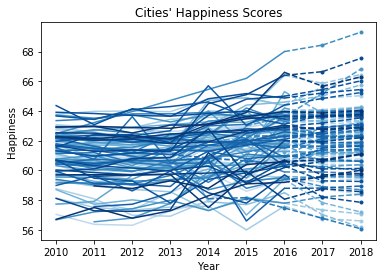

In [ ]:
# the cities we've ended up with data for, which is 7 fewer than our original wishlist
final_cities = set(data.index.get_level_values('city'))

for i, city in enumerate(final_cities):
    years = np.array([int(year) for year in data['happiness'].loc[city].index])
    happinesses = np.array(data['happiness'].loc[city].values)
    
    new_years = np.array(range(years[-1]+1, 2018+1))
    new_happinesses = sk_LinearRegression() \
                      .fit(years.reshape((-1, 1)), happinesses.reshape((-1, 1))) \
                      .predict(new_years.reshape((-1, 1)))

    color = plt.get_cmap('Blues')(i*.75/len(final_cities)+.25)
    plt.plot(years, happinesses, '-', c=color)
    plt.plot([years[-1], new_years[0]], [happinesses[-1], new_happinesses[0]], '--', c=color)
    plt.plot(new_years, new_happinesses, '.--', c=color)
plt.title("Cities' Happiness Scores")
plt.ylabel("Happiness")
plt.xlabel("Year")
plt.show()

No contest here—Honolulu is projected to be the happiest city for apparently all of time.

# Privacy/Ethics Considerations

For our purpose of this project, all of our data used are public available online. There are no privacy concerns regarding the datasets, as it is presented online by the Census and FBI. All our datasets have different populations presented without excluding any groups. However, there may be some unaccounted individuals who did not fill out surveys for the Census. For the most part, Census surveys are filled out by individuals since it is required. We have no privacy issues in our data because everything is posted online to the public and contain no personal information of any sort.

# Conclusions and Discussion

The original purpose of our study was to find the happiest city in the world, however we changed it to finding it within the United States because it was not feasible to have that many cities represented.

We decided to just focus on the United States and chose two to three cities from each state. We discovered that cities with higher standards of living had sexual assaults reported more often. This data shows higher occurrences of rape whereas in smaller cities this crime goes unreported and ignored. In the happiest cities we also noticed there are more vehicle thefts. We concluded that in the happiest cities people tend to buy more expensive cars and they are more likely to get stolen. To make our data more accurate to predict the happiness in the future we added date describing the weather, rain, humidity, wind speed and sunshine of the city. As we worked on our project we learned exactly what makes a city a happy city. A city’s happiness is due not only to its crime levels but also the amount of time it takes to commute to work, the population of residents, income rate, and unemployment.

After we gathered some data we noticed that Honolulu has been the happiest city for two years in a row. In 2015 and 2016 Honolulu, Hawaii was the happiest city to live in. Based on our conclusions it was the happiest city to live in because of their small population so there would be less traffic and commuting to different areas would be easier. There are less crimes in Honolulu which makes it easier for individuals to live there without fear for their safety. The added year round sunshine in this is another significant factor in the high levels of happiness among the locals.